In [1]:
#MODULES
import pandas as pd
from datetime import datetime,timedelta
import holidays
# Detect US holidays
#hldys = holidays.country_holidays('US')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
pd.set_option('display.max_columns', None)


This dataset provides daily stock prices and volume of Apple. 
Here are columns description:
| Column    | Description                                                      |
|-----------|------------------------------------------------------------------|
| Date      | Date of trading day                                              |
| Open      | Stock price at market open                                       |
| High      | Highest stock price during the trading day                       |
| Low       | Lowest stock price during the trading day                        |
| Close     | Stock price at market close                                      |
| Adj Close | Adjusted closing price accounting for dividends and stock splits |
| Volume    | Number of shares traded.                                         |

In [2]:
input_data = pd.read_csv("./data/AppleStockPrice.csv")#csv taken from -> https://www.kaggle.com/datasets/muhammadbilalhaneef/-apple-stock-prices-from-1981-to-2023
#input_data.columns = input_data.columns.str.lower()
input_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,0.091630,73449600
...,...,...,...,...,...,...,...
11030,16-09-2024,216.540000,217.220000,213.920000,216.320000,216.320000,59357400
11031,17-09-2024,215.750000,216.900000,214.500000,216.790000,216.790000,45519300
11032,18-09-2024,217.550000,222.710000,217.540000,220.690000,220.690000,59894900
11033,19-09-2024,224.990000,229.820000,224.630000,228.870000,228.870000,66781300


In [3]:
input_data = pd.read_csv("./data/AppleStockPrice.csv")#csv taken from -> https://www.kaggle.com/datasets/muhammadbilalhaneef/-apple-stock-prices-from-1981-to-2023
input_data.columns = input_data.columns.str.strip().str.lower().str.replace(" ","_")
input_data['date'] = pd.to_datetime(input_data['date'],format='%d-%m-%Y')
input_data.set_index('date',inplace=True)
input_data.sort_index(inplace=True)
print("\n NA's\n",input_data.isna().sum())#checking for NA's
print("\n Dtypes--->\n",input_data.dtypes)#seems ok
print("\n duplicates:\n",sum(input_data.duplicated()))


 NA's
 open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

 Dtypes--->
 open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object

 duplicates:
 0


In [4]:
input_data

,open,high,low,close,adj_close,volume
date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600
...,...,...,...,...,...,...
2024-09-16,216.540000,217.220000,213.920000,216.320000,216.320000,59357400
2024-09-17,215.750000,216.900000,214.500000,216.790000,216.790000,45519300
2024-09-18,217.550000,222.710000,217.540000,220.690000,220.690000,59894900


# Cutting on dates: 2015-2024


In [5]:
input_data = input_data[
            (input_data.index>=pd.to_datetime('2015-01-01')) 
            &
            (input_data.index<=pd.to_datetime('2024-01-01'))
           ]

# Plotting Timeseries

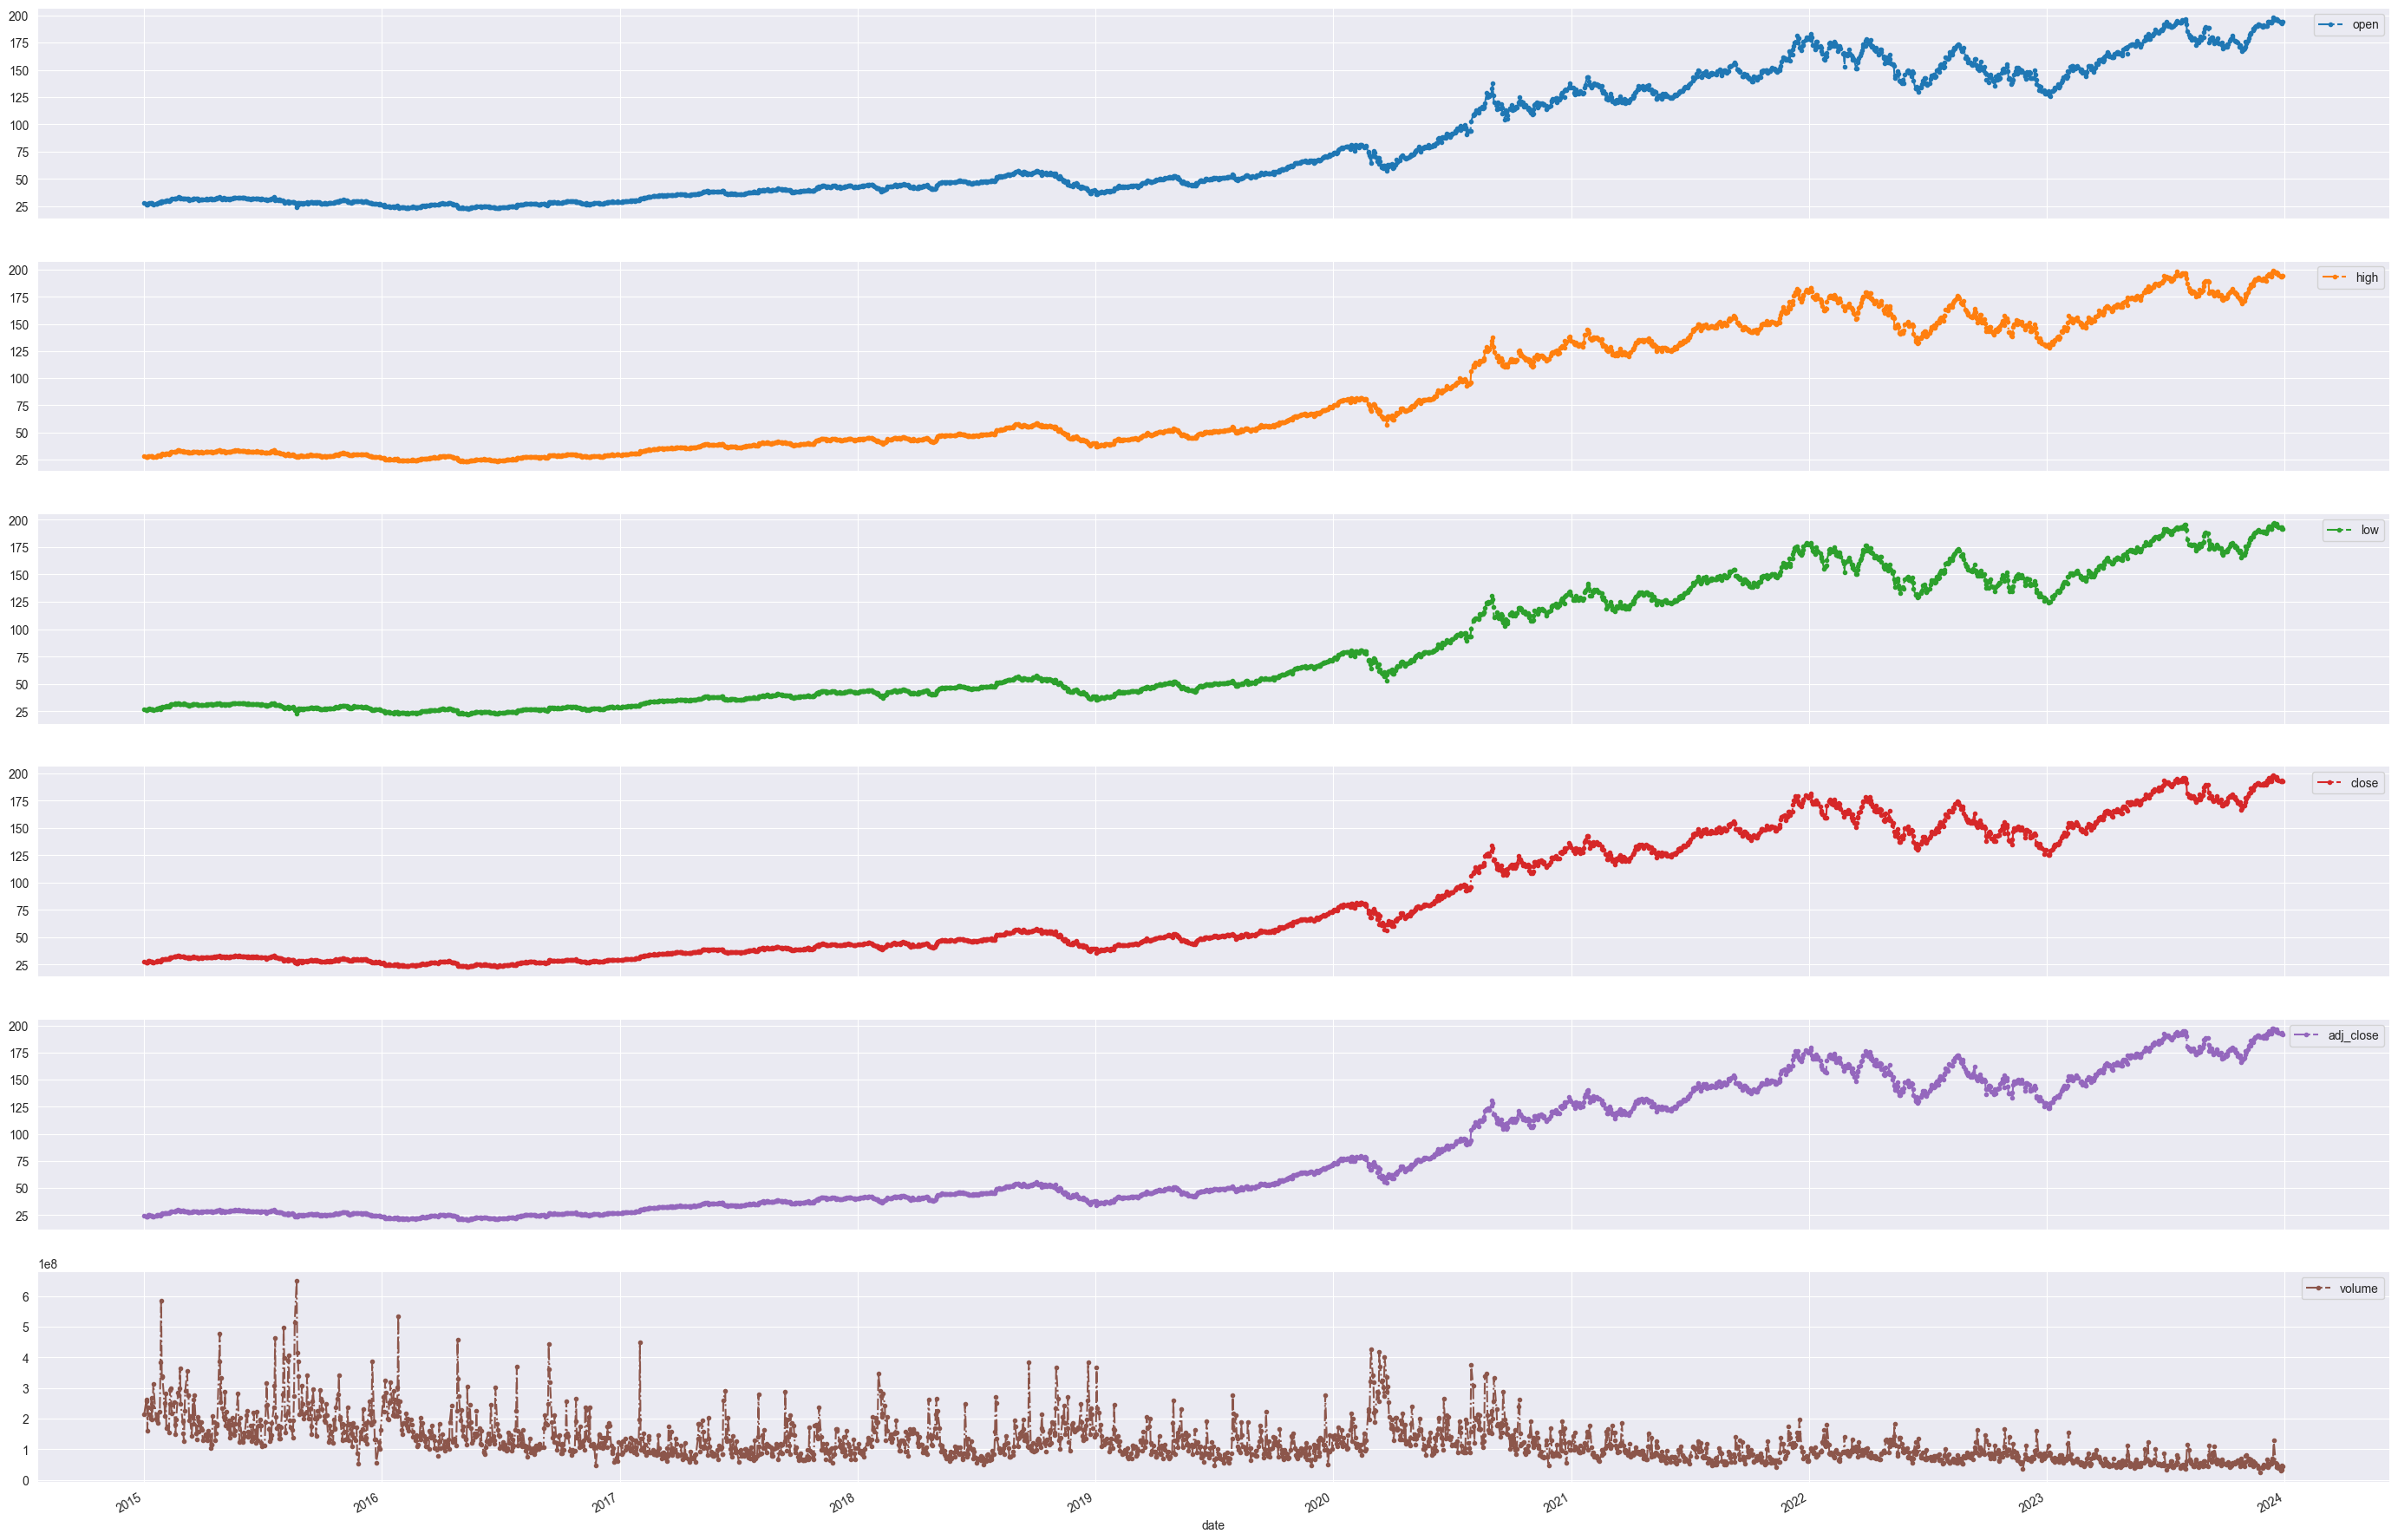

In [6]:
input_data.plot(figsize=(35,25),marker='.',linestyle='-.',subplots=True);


# US Public Holidays

In [7]:
us_public_holidays = pd.Series(
                               holidays.country_holidays(
                                                         'US',  years = range(
                                                             input_data.index.min().year,
                                                             input_data.index.max().year+1
                                                            )
                                                        )
                              )
us_public_holidays = pd.DataFrame(us_public_holidays).reset_index().rename(columns={'index':'Date',0:'holiday_name'}).set_index('Date').sort_index()
us_public_holidays

,holiday_name
Date,
2015-01-01,New Year's Day
2015-01-19,Martin Luther King Jr. Day
2015-02-16,Washington's Birthday
2015-05-25,Memorial Day
2015-07-03,Independence Day (observed)
...,...
2023-10-09,Columbus Day
2023-11-10,Veterans Day (observed)
2023-11-11,Veterans Day


### By resampling we can locate the missing dates
### we flag them weekend OR US holiday


In [8]:
input_data_nan = input_data.resample('D').asfreq()
input_data_nan = input_data_nan.join(us_public_holidays)#adding holidays
input_data_nan['day_name'] = pd.to_datetime(input_data_nan.index).day_name();#adding nameday
input_data_nan['holiday_name'] = input_data_nan.apply(lambda row: 'weekend' if (row.day_name in ['Saturday','Sunday'] and pd.isnull(row.holiday_name)) else row.holiday_name, axis=1)#weekend flag only if there is no holiday_name already filled
input_data_nan = input_data_nan[input_data_nan[input_data_nan.columns[0]].isna()]#select Missing rows (by chosing the first column randomly "0")
input_data_nan

,open,high,low,close,adj_close,volume,holiday_name,day_name
date,,,,,,,,
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2015-01-10,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2015-01-11,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2015-01-17,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
...,...,...,...,...,...,...,...,...
2023-12-16,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday
2023-12-17,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Sunday
2023-12-23,NaN,NaN,NaN,NaN,NaN,NaN,weekend,Saturday


### distribution of US holidays along the week days


In [9]:
pd.DataFrame(input_data_nan.groupby(['day_name','holiday_name']).size()).rename(columns={0:'counts'}).sort_index().head(40)

counts
day_name  holiday_name                                           
Friday    Christmas Day                                         2
          Christmas Day (observed)                              1
          Independence Day (observed)                           2
          New Year's Day                                        2
Monday    Christmas Day                                         2
          Christmas Day (observed)                              2
          Independence Day                                      2
          Independence Day (observed)                           1
          Juneteenth National Independence Day                  1
          Juneteenth National Independence Day (observed)       1
          Labor Day                                             9
          Martin Luther King Jr. Day                            9
          Memorial Day                                          9
          New Year's Day                                        1
          New Year's Day (observed)                             2
          Washington's Birthday                                 9
Saturday  Christmas Day                                         1
          Independence Day                                      2
          Juneteenth National Independence Day                  1
          New Year's Day                                        1
          Veterans Day                                          2
          weekend                                             462
Sunday    Christmas Day                                         2
          Independence Day                                      1
          Juneteenth National Independence Day                  1
          New Year's Day                                        2
          Veterans Day                                          1
          weekend                                             462
Thursday  Independence Day                                      1
          Thanksgiving                                          9
Tuesday   Christmas Day                                         1
          Independence Day                                      2
          New Year's Day                                        1
Wednesday Christmas Day                                         1
          Independence Day                                      1
          New Year's Day                                        1

# checking for missing consecutive dates


In [10]:
df = input_data_nan.reset_index()[['date']]
df.sort_values('date',inplace=True)
df['time_diff'] = df['date'].diff()
one_day = timedelta(days=1) 
df['group'] = (df['time_diff'] > one_day).cumsum()#differentiate the group that consecutive days belong to
df

,date,time_diff,group
0,2015-01-03,NaT,0
1,2015-01-04,1 days,0
2,2015-01-10,6 days,1
3,2015-01-11,1 days,1
4,2015-01-17,6 days,2
...,...,...,...
1015,2023-12-16,6 days,485
1016,2023-12-17,1 days,485
1017,2023-12-23,6 days,486
1018,2023-12-24,1 days,486


(1.0, 1000.0)

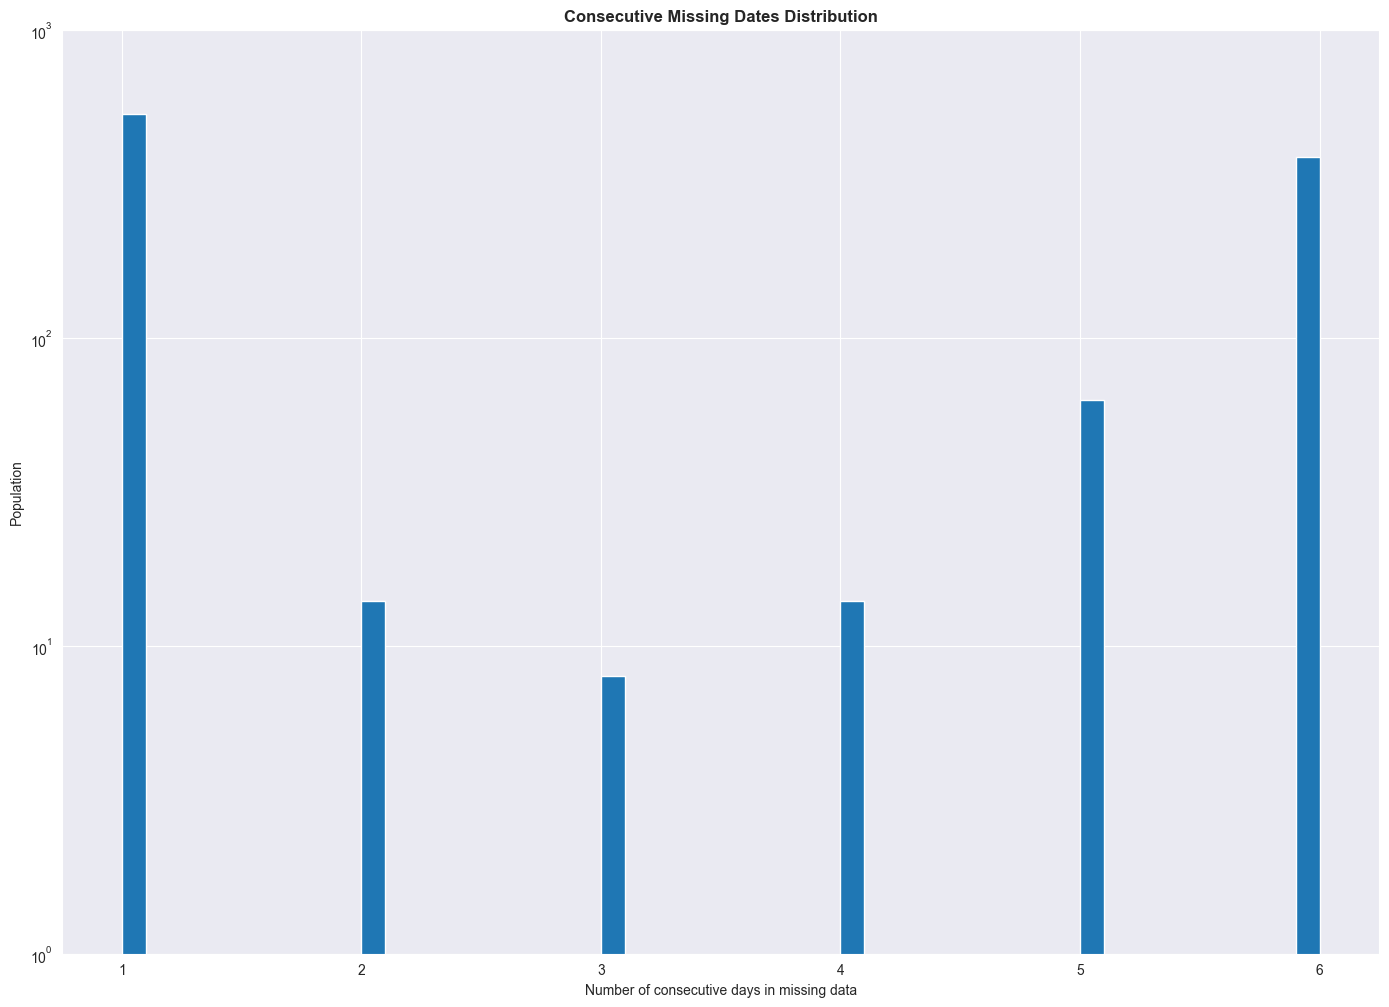

In [11]:
(df['time_diff'].dt.total_seconds()/(3600*24)).hist(bins=50,log=True,figsize=(17,12))
plt.xlabel('Number of consecutive days in missing data')
plt.ylabel('Population')
plt.title('Consecutive Missing Dates Distribution',fontweight = "bold")
plt.ylim(1e+0,1e+3)

# There exist two ways of treating _missing values_
## Create the dates and interpolate them OR 
## Ignore them and work only with trading days

# Creating the daily_return and the extreme_event flag
###



In [12]:
 #Calculate Daily Returns based on input_data['daily_return'] = (input_data[selected_column]- input_data[selected_column].shift(-1))/input_data[selected_column].shift(-1) <=> pd.pct(periods=-1) <- CHECKED!
margin = 0.02
input_data.loc[:,'daily_return'] = input_data['adj_close'].pct_change(periods=-1)
input_data.dropna(inplace=True)
input_data.loc[:,'extreme_event'] = np.where(np.abs(input_data['daily_return'])>margin,1,0)
display(input_data)

C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\2650664306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:,'daily_return'] = input_data['adj_close'].pct_change(periods=-1)
C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\2650664306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.dropna(inplace=True)
C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\2650664306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,open,high,low,close,adj_close,volume,daily_return,extreme_event
date,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400,0.028988,1
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,-0.000094,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689531,263188400,-0.013829,0
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021717,160423600,-0.037000,1
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000,-0.001071,0
...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,0.005578,0
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800,0.002849,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,-0.000518,0


# Timeseries of extreme_events = 0 or 1
## green area indicates that the event is not extreme (0)
## all the points outside that area are considered extreme (1)

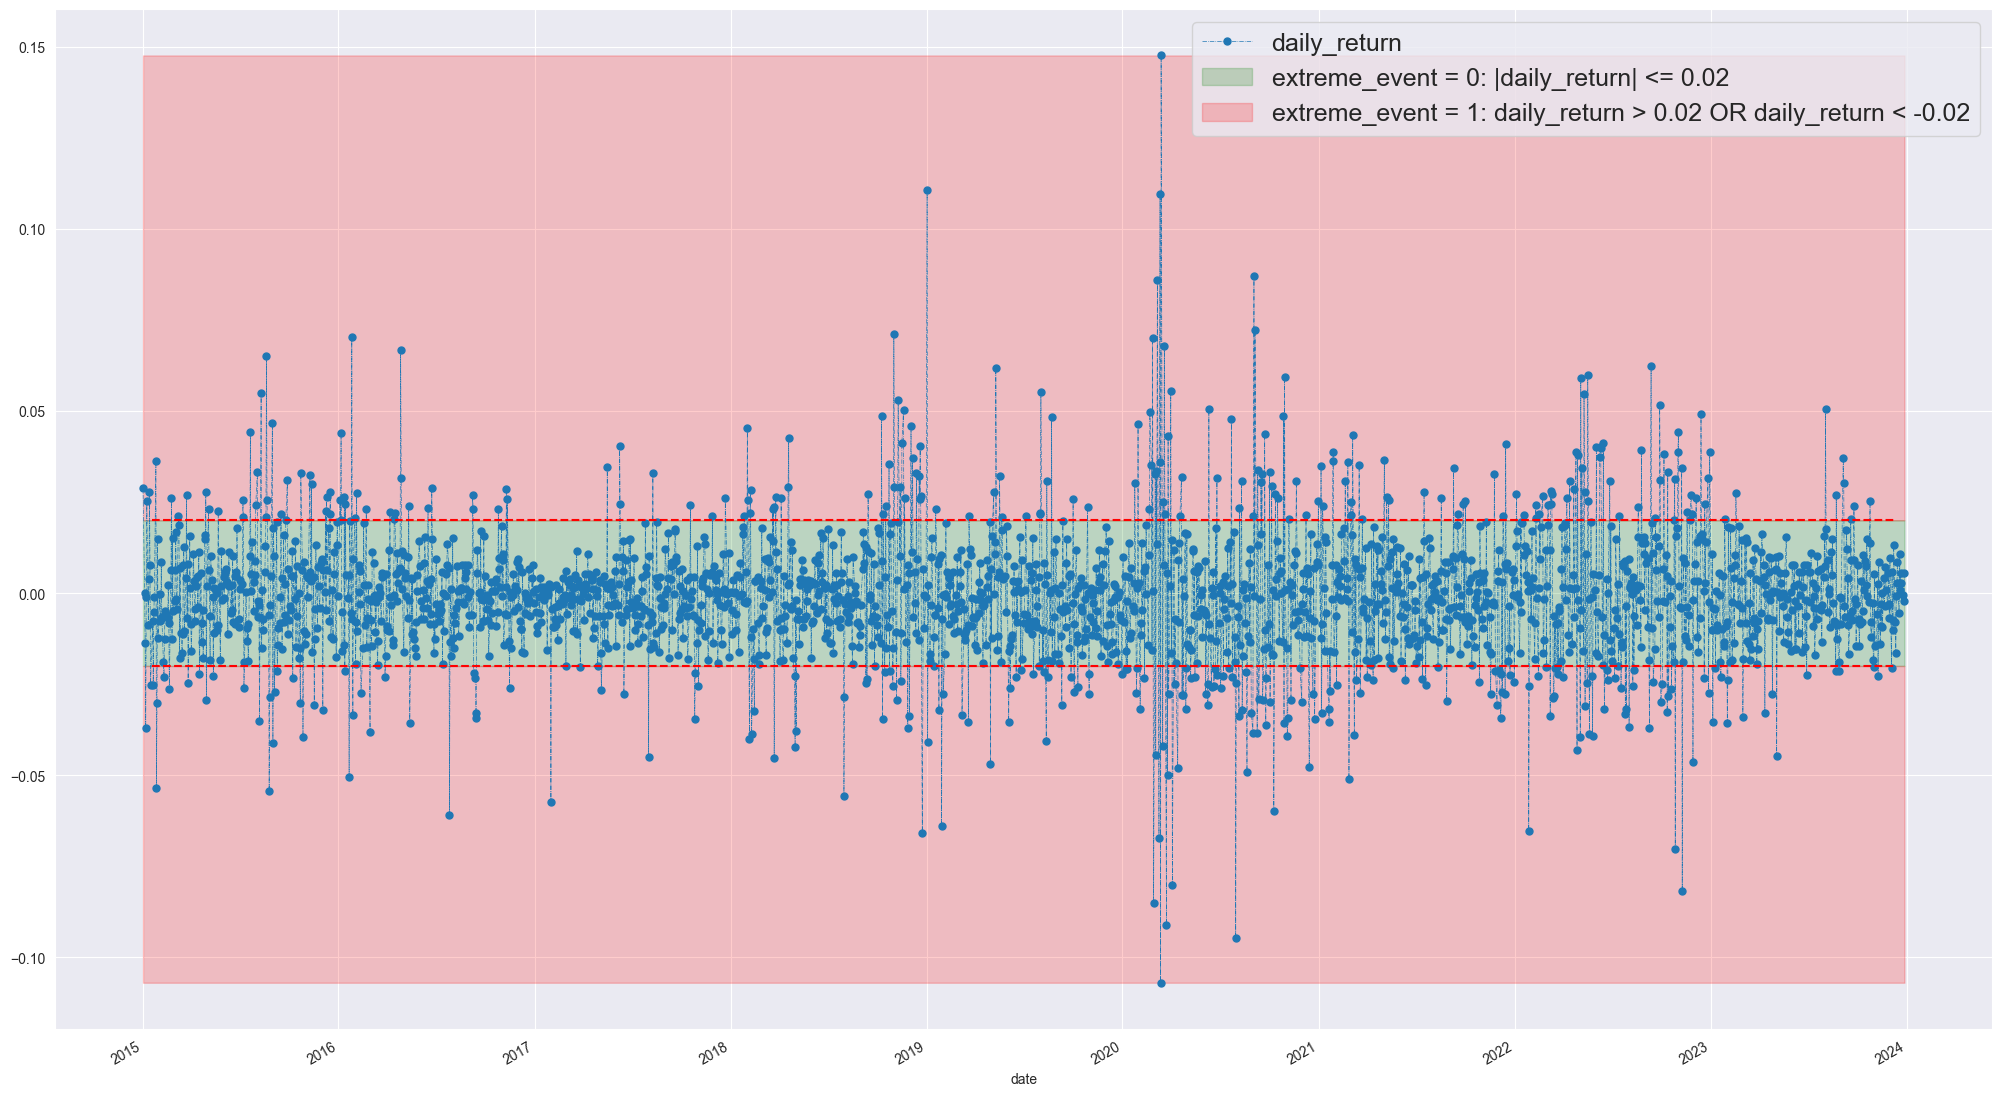

In [13]:
input_data.plot(y='daily_return',marker='.',linestyle='-.',linewidth=.5,ms=10,figsize=(25,15))
plt.axhline(xmin=0.05,xmax=.95,y=margin, color='red', linestyle='--')
plt.axhline(xmin=0.05,xmax=.95,y=-margin, color='red', linestyle='--')
plt.fill_between(x=input_data.index,y1=margin,y2=-margin,color='green',alpha=0.2,label=f'extreme_event = 0: |daily_return| <= {margin}')
plt.fill_between(x=input_data.index,y1=+margin,y2=input_data.daily_return.max(),color='red',alpha=0.2,label=f'extreme_event = 1: daily_return > {margin} OR daily_return < -{margin}')
plt.fill_between(x=input_data.index,y1=-margin,y2=input_data.daily_return.min(),color='red',alpha=0.2)#no need for label
plt.legend(fontsize=18)

# Overall Distributions (both for 0 and 1)

array([[<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'high'}>,
        <Axes: title={'center': 'low'}>],
       [<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'adj_close'}>,
        <Axes: title={'center': 'volume'}>],
       [<Axes: title={'center': 'daily_return'}>,
        <Axes: title={'center': 'extreme_event'}>, <Axes: >]],
      dtype=object)

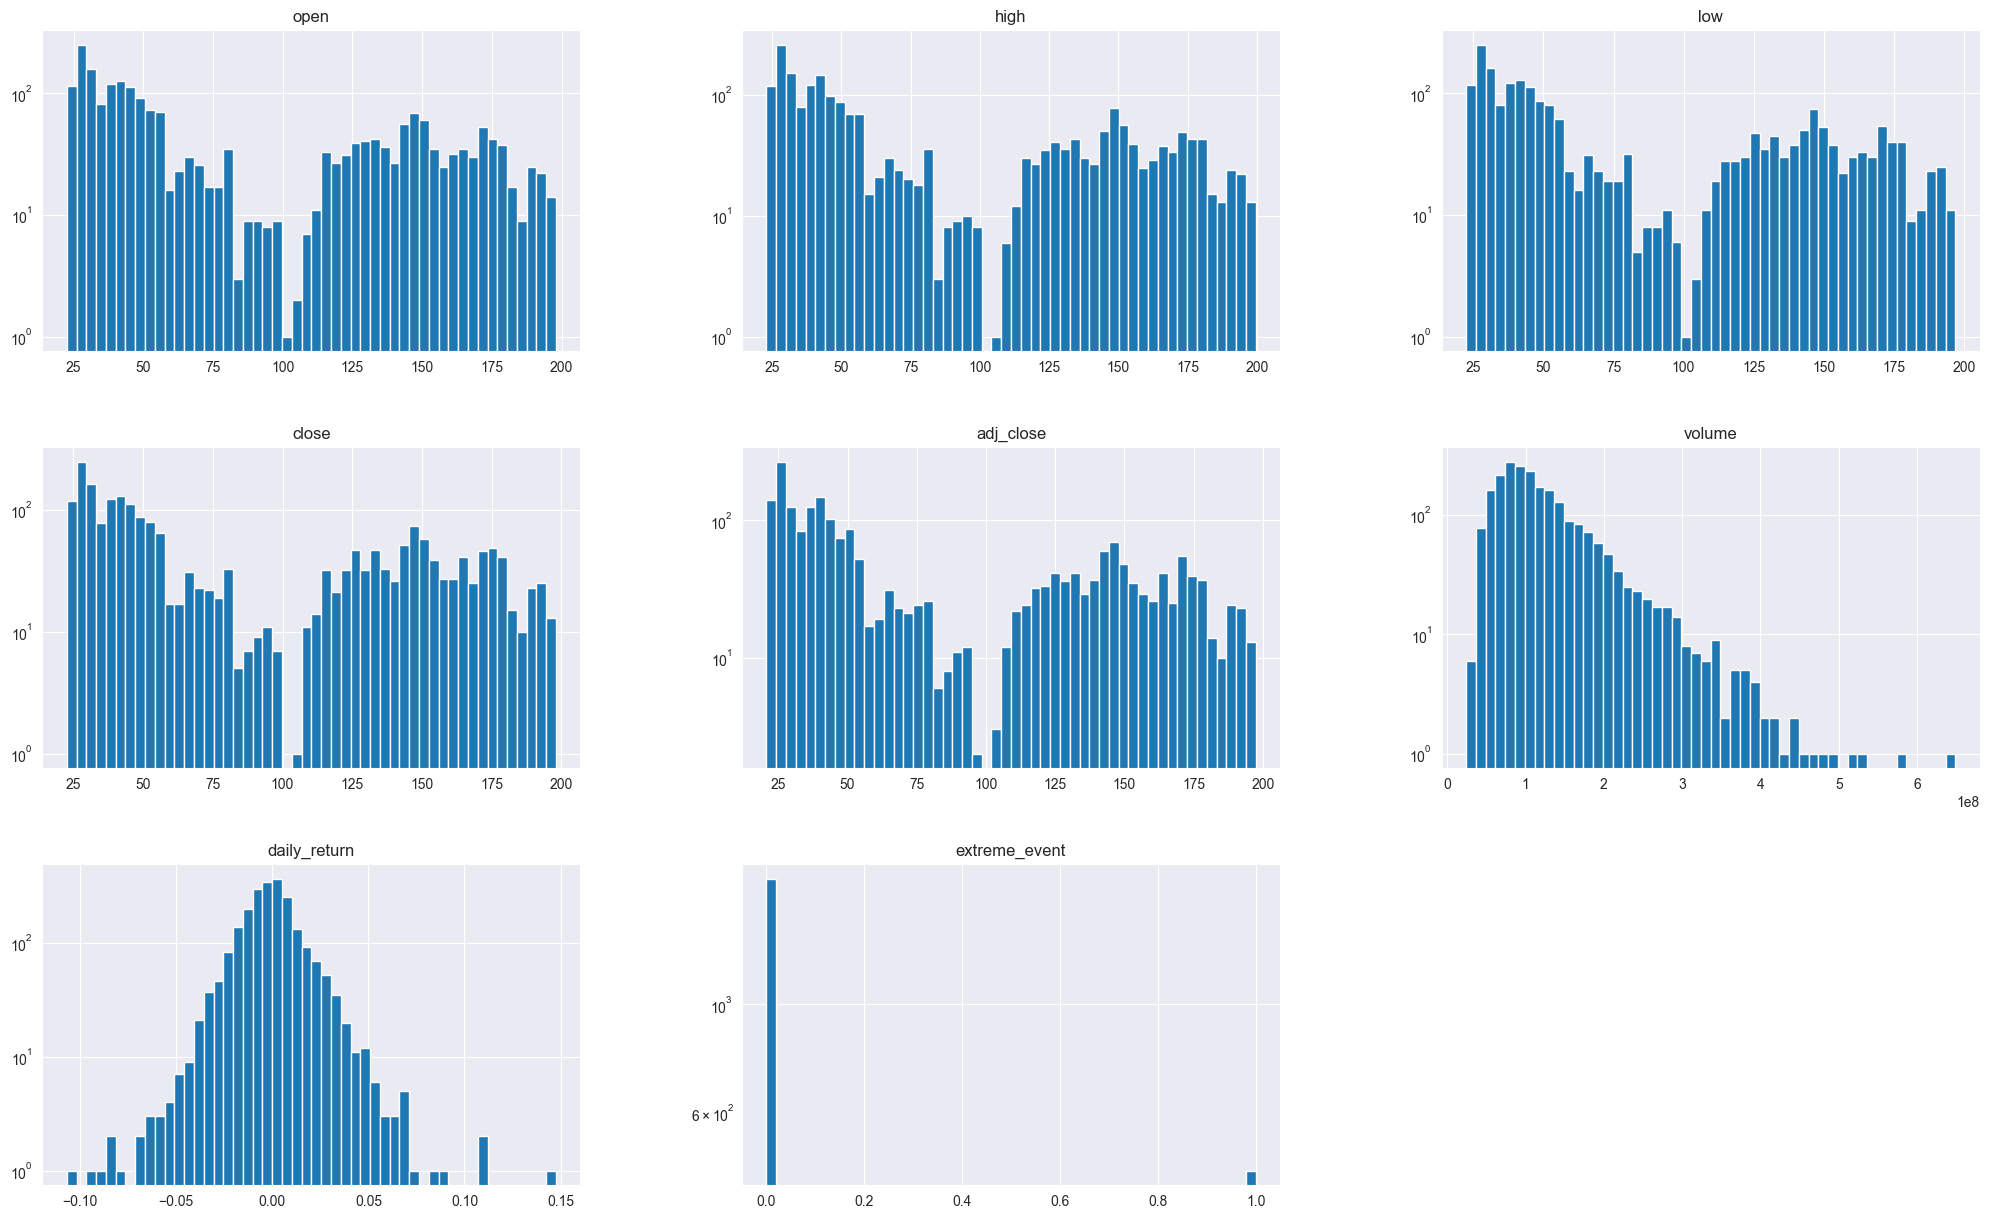

In [14]:
input_data.hist(bins=50,log=True,figsize=(25,15))

# Split Distributions based on extreme_event=0 or 1

extreme_event
0    [[Axes(0.125,0.666111;0.215278x0.213889), Axes(0.404861,0.666111;0.215278x0.213889), Axes(0.684722,0.666111;0.215278x0.213889)], [Axes(0.125,0.388056;0.215278x0.213889), Axes(0.404861,0.388056;0.215278x0.213889), Axes(0.684722,0.388056;0.215278x0.213889)], [Axes(0.125,0.11;0.215278x0.213889), Axes(0.404861,0.11;0.215278x0.213889), Axes(0.684722,0.11;0.215278x0.213889)]]
1    [[Axes(0.125,0.666111;0.215278x0.213889), Axes(0.404861,0.666111;0.215278x0.213889), Axes(0.684722,0.666111;0.215278x0.213889)], [Axes(0.125,0.388056;0.215278x0.213889), Axes(0.404861,0.388056;0.215278x0.213889), Axes(0.684722,0.388056;0.215278x0.213889)], [Axes(0.125,0.11;0.215278x0.213889), Axes(0.404861,0.11;0.215278x0.213889), Axes(0.684722,0.11;0.215278x0.213889)]]
dtype: object

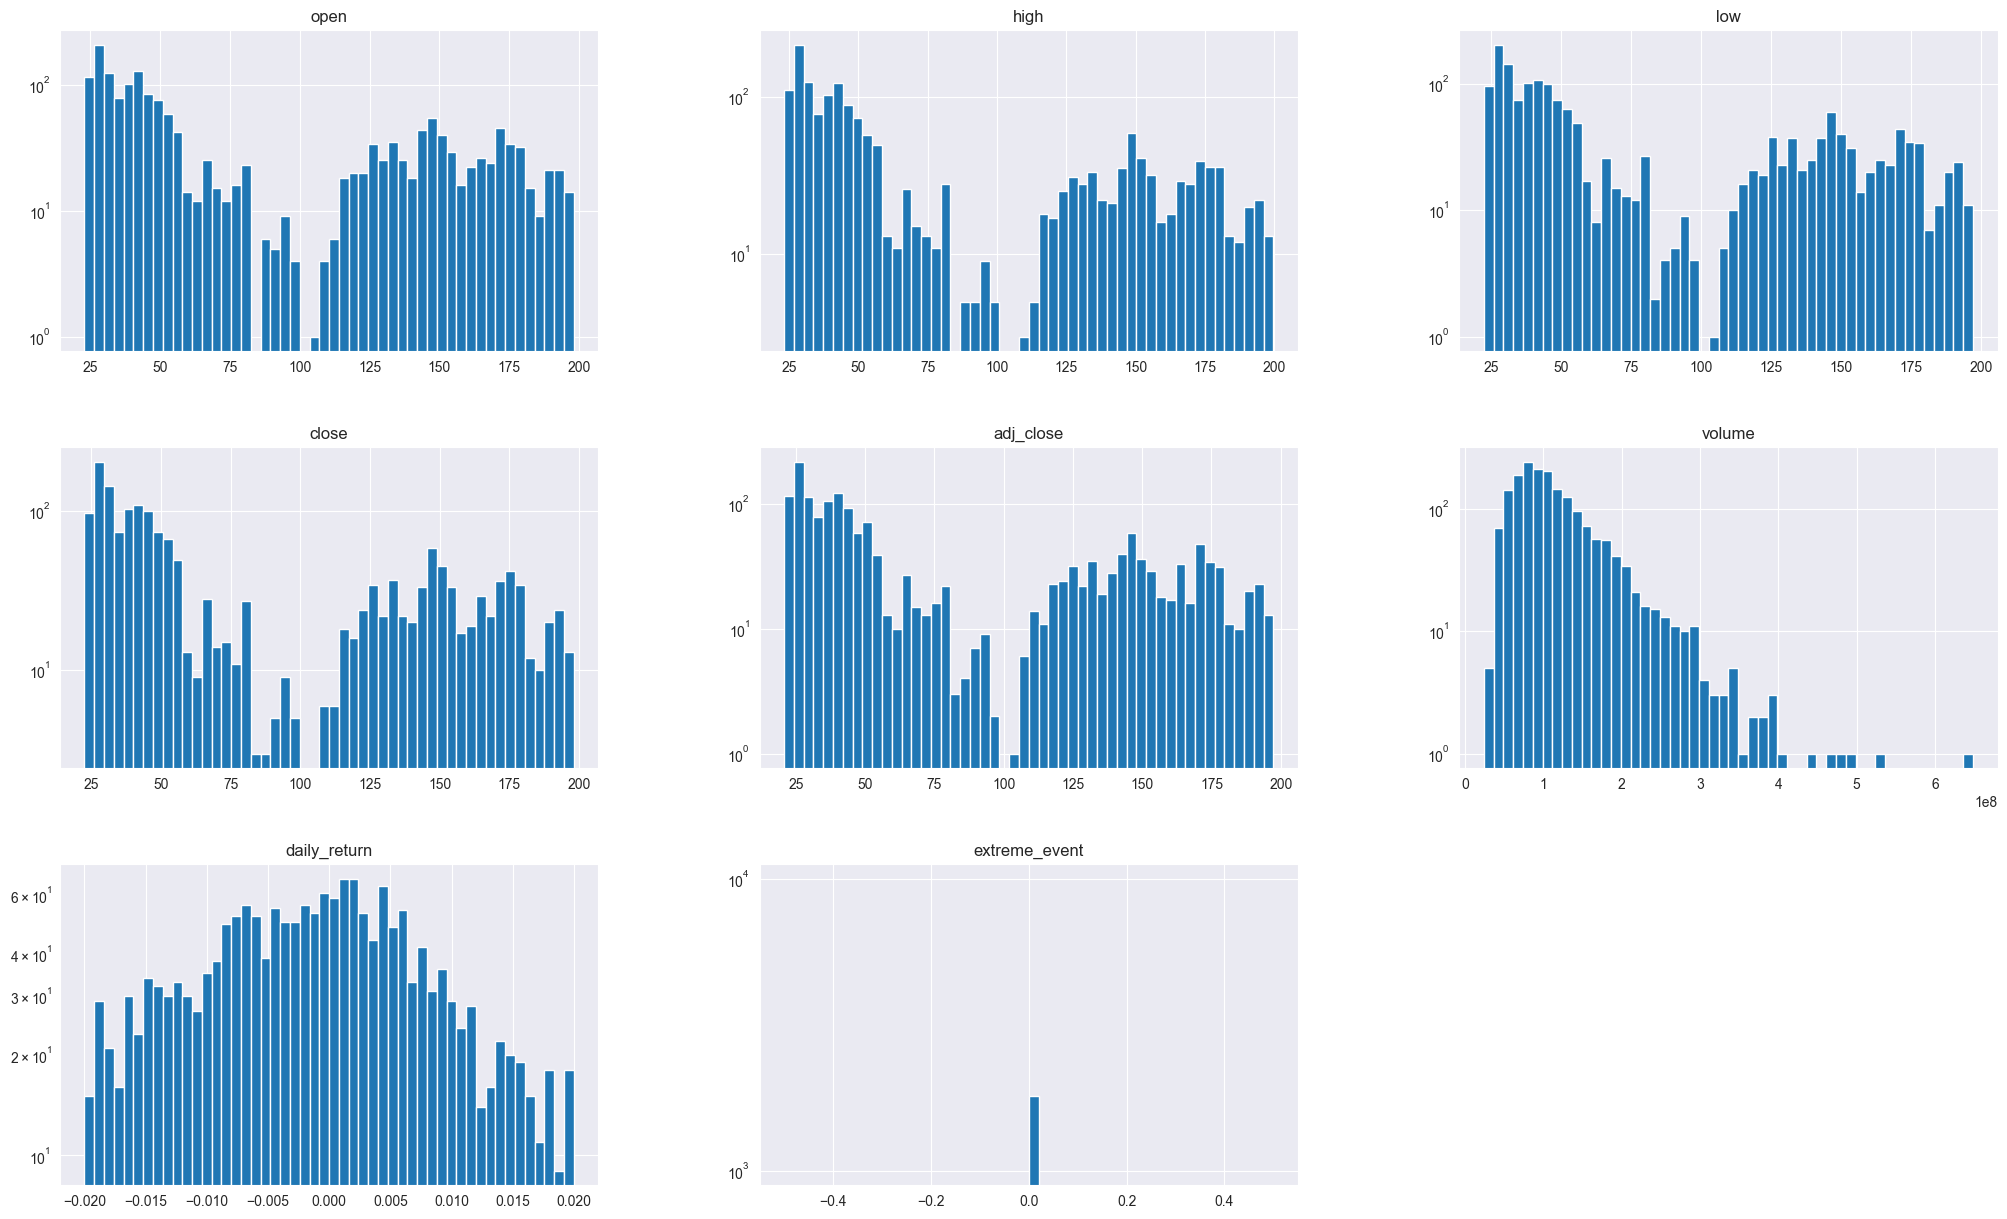

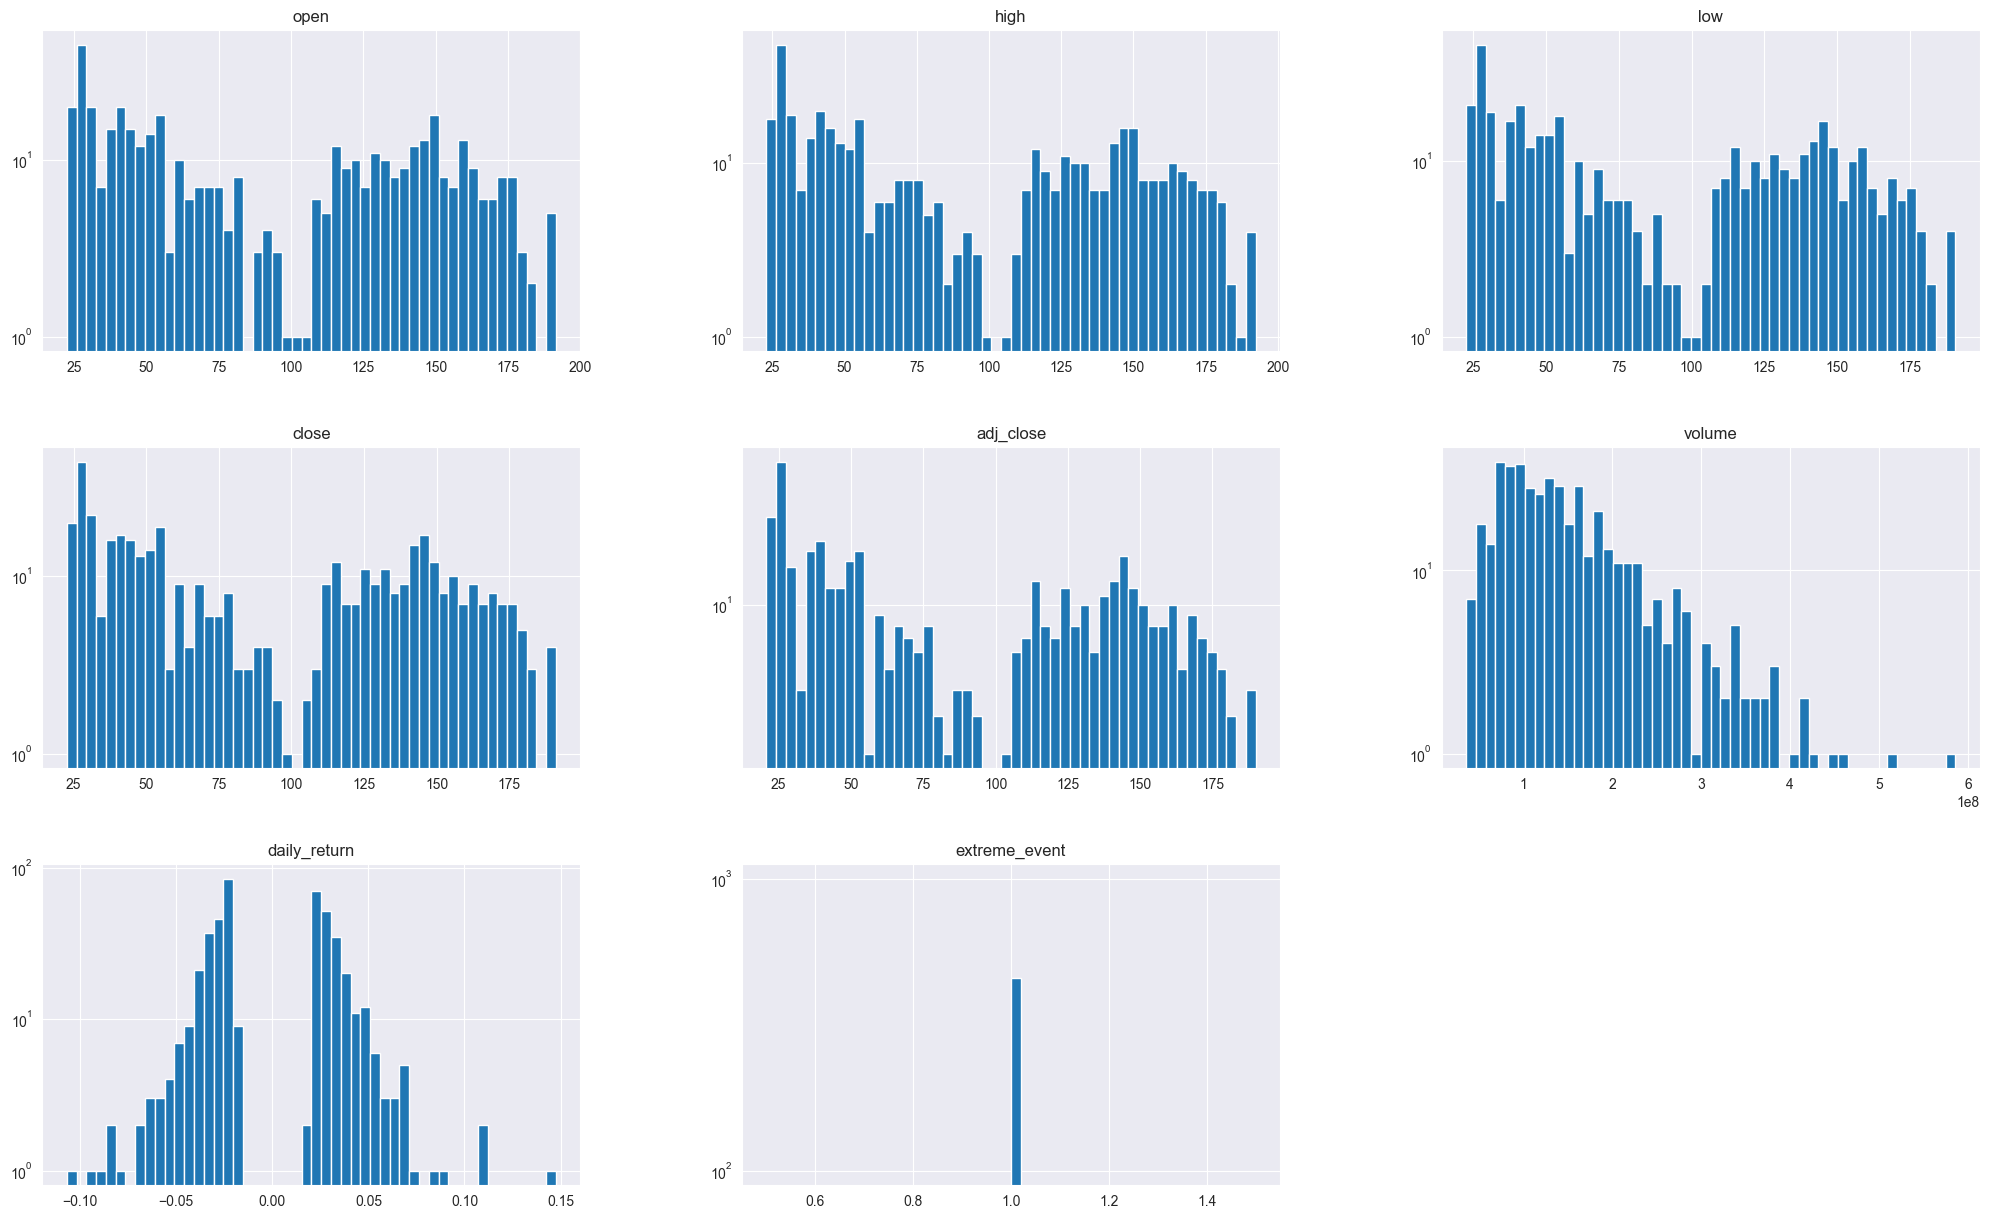

In [15]:
#All hists based on extreme or not event
input_data.groupby('extreme_event').hist(figsize=(25,15),bins=50,log=True)

# same info as above but with overlay plots

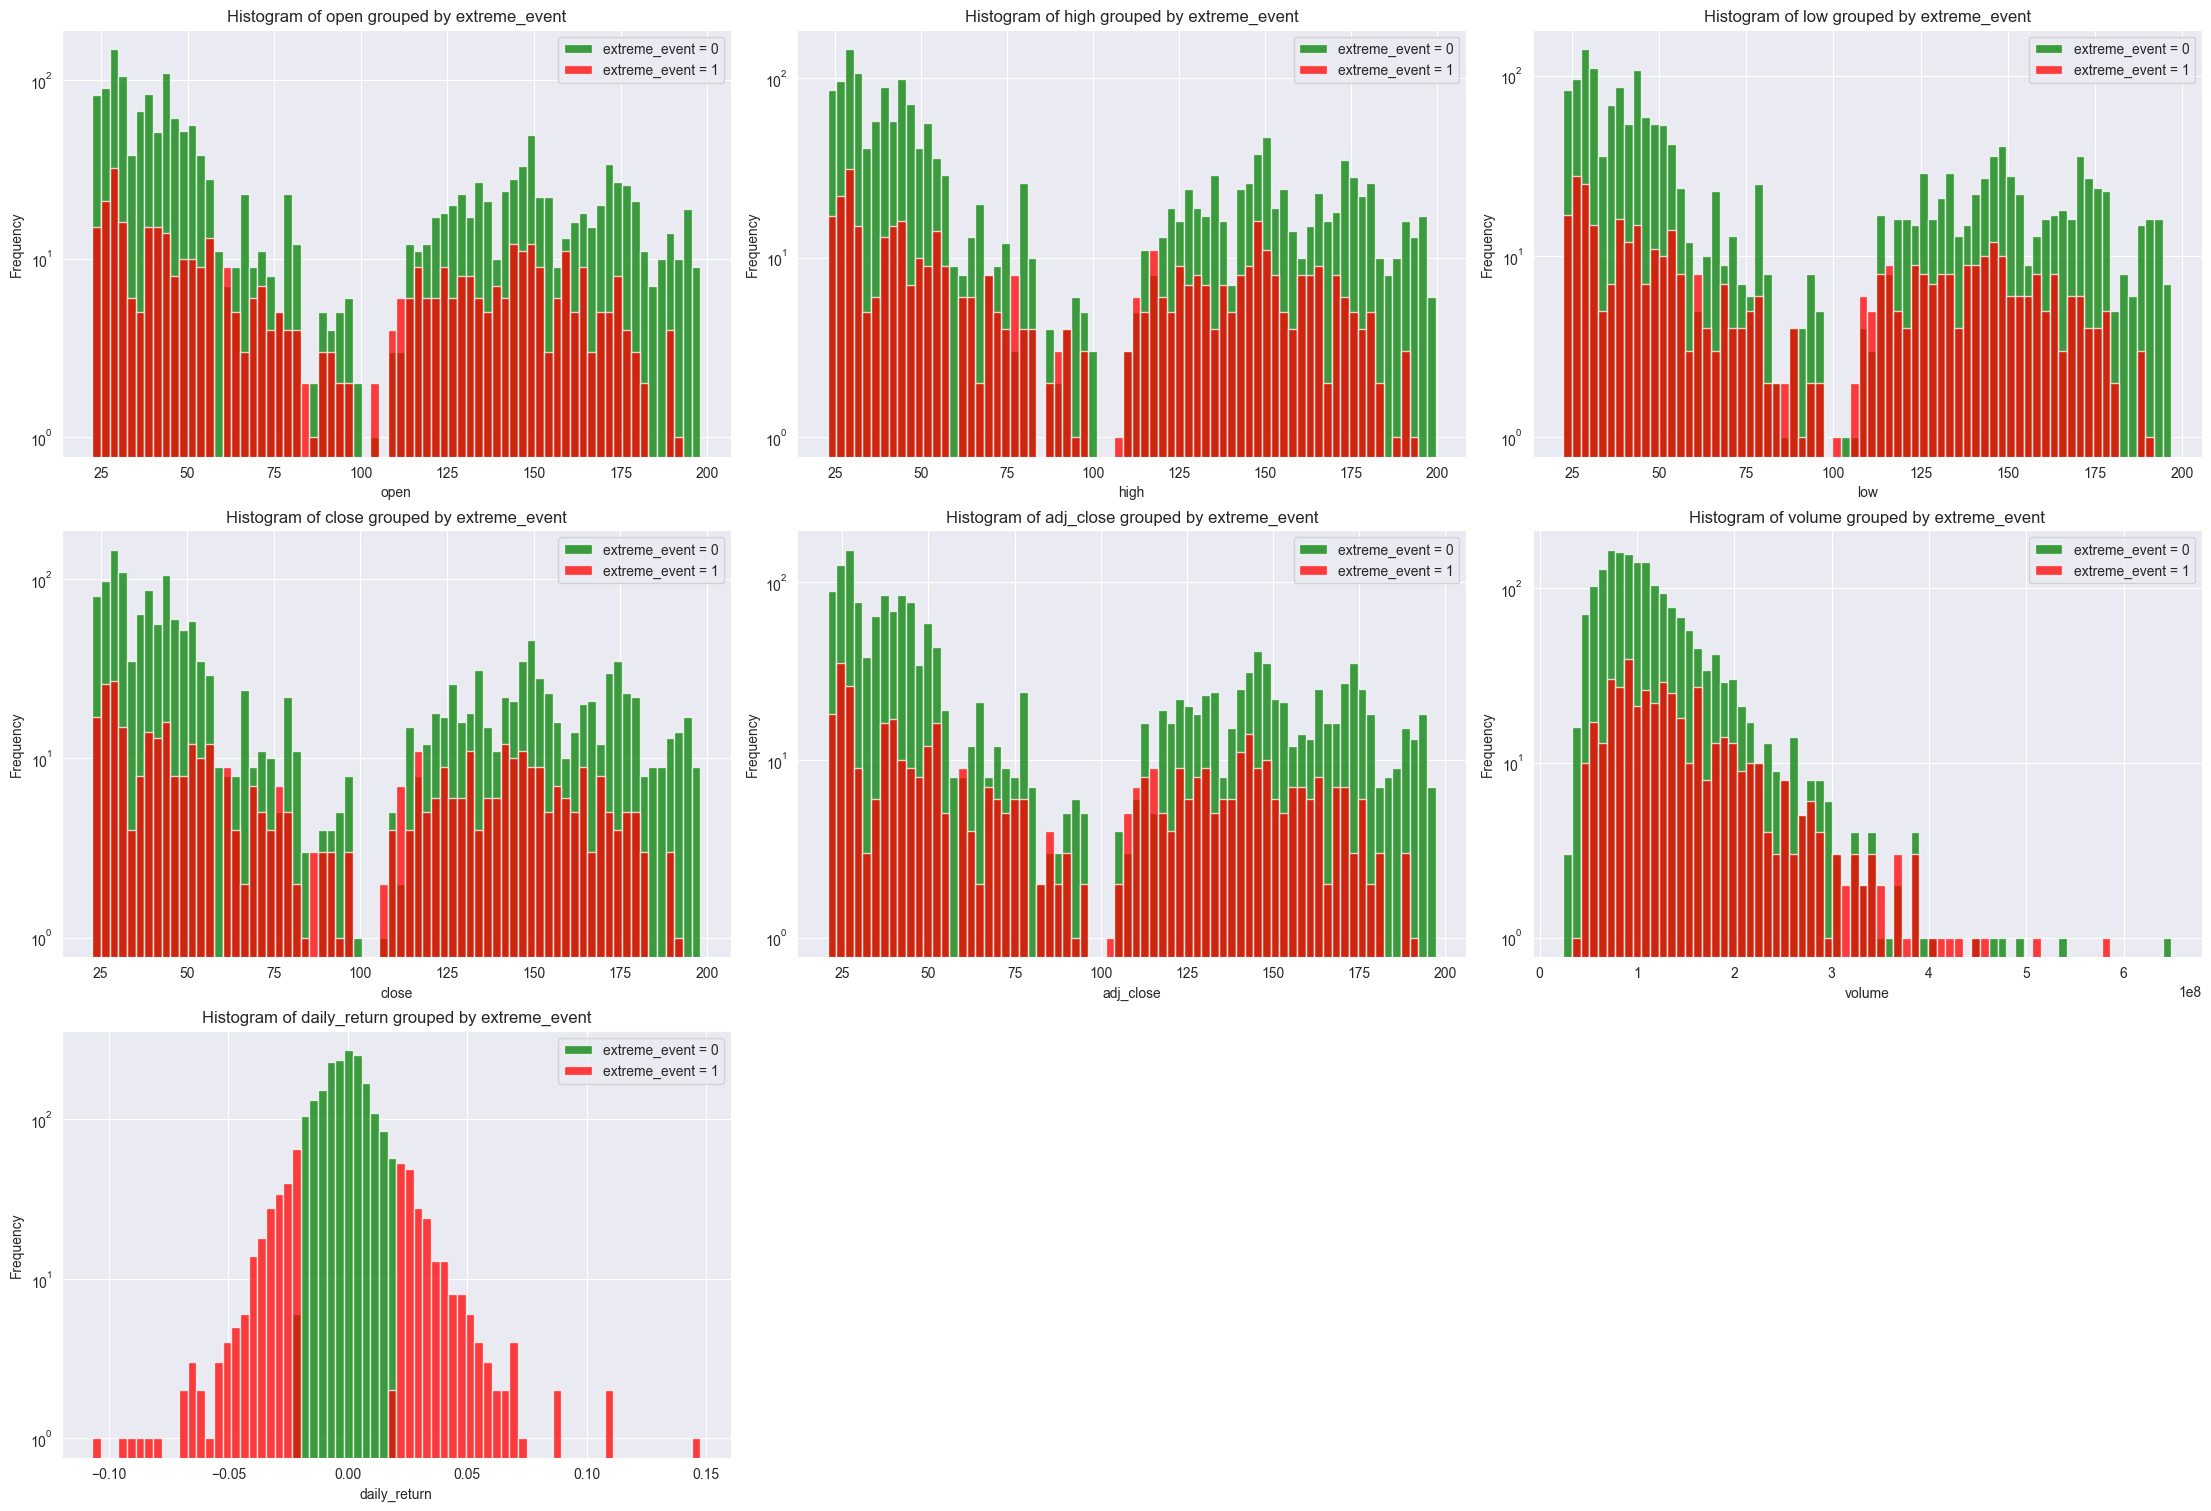

In [16]:
df = input_data.loc[:,input_data.columns!='day_name']
#data.loc[:, data.columns != 'name']
# Define the grouping column and color dictionary
group_column = 'extreme_event'
color_dict = {0: 'green', 1: 'red'}  # Adjust keys to match actual unique values in extreme_event
n_cols = 3  # Number of columns in the grid layout
n_rows = (len(df.columns) - 1) // n_cols + 1  # Calculate rows needed, excluding 'extreme_event'
# Set up the figure and axes for the grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5 * n_rows), constrained_layout=True)
# Flatten axes to make it easier to iterate, even for single rows/columns
axes = axes.flatten()
# Loop through each column except the grouping column
for i, plot_column in enumerate([col for col in df.columns if col != group_column]):
    # Calculate the global min and max for each plot_column
    global_min = df[plot_column].min()
    global_max = df[plot_column].max()
    num_bins = 70  # Set the desired number of bins
    # Define global bin edges across the column's min and max range
    bin_edges = np.linspace(global_min, global_max, num_bins + 1)
    # Loop through each group in the grouping column to plot on the same subplot
    for name, group in df.groupby(group_column):
        custom_color = color_dict.get(name, 'blue')  # Use color from dictionary, default to 'blue' if not found
        axes[i].hist(group[plot_column], bins=bin_edges, alpha=0.75, label=f'{group_column} = {name}', log = True, color=custom_color)
    # Set labels, title, and legend for each subplot
    axes[i].set_xlabel(plot_column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {plot_column} grouped by {group_column}')
    axes[i].legend()
# Hide any empty subplots if there are extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

### Investigating further the distributions based on -1 or +1 (neg_extreme_event or positive extreme_event)

In [17]:
#create extreme_pos and extreme_neg based on the sign of daily_returns
df = input_data.copy()
df['extreme_pos']        = np.where(np.sign(df['daily_return'])*df['extreme_event']==+1,1,0)
df['extreme_neg']        = np.where(np.sign(df['daily_return'])*df['extreme_event']==-1,-1,0)
df['extreme_event_sign'] = df['extreme_neg'] + df['extreme_pos']
df.drop(['extreme_pos','extreme_neg'],axis=1,inplace=True)

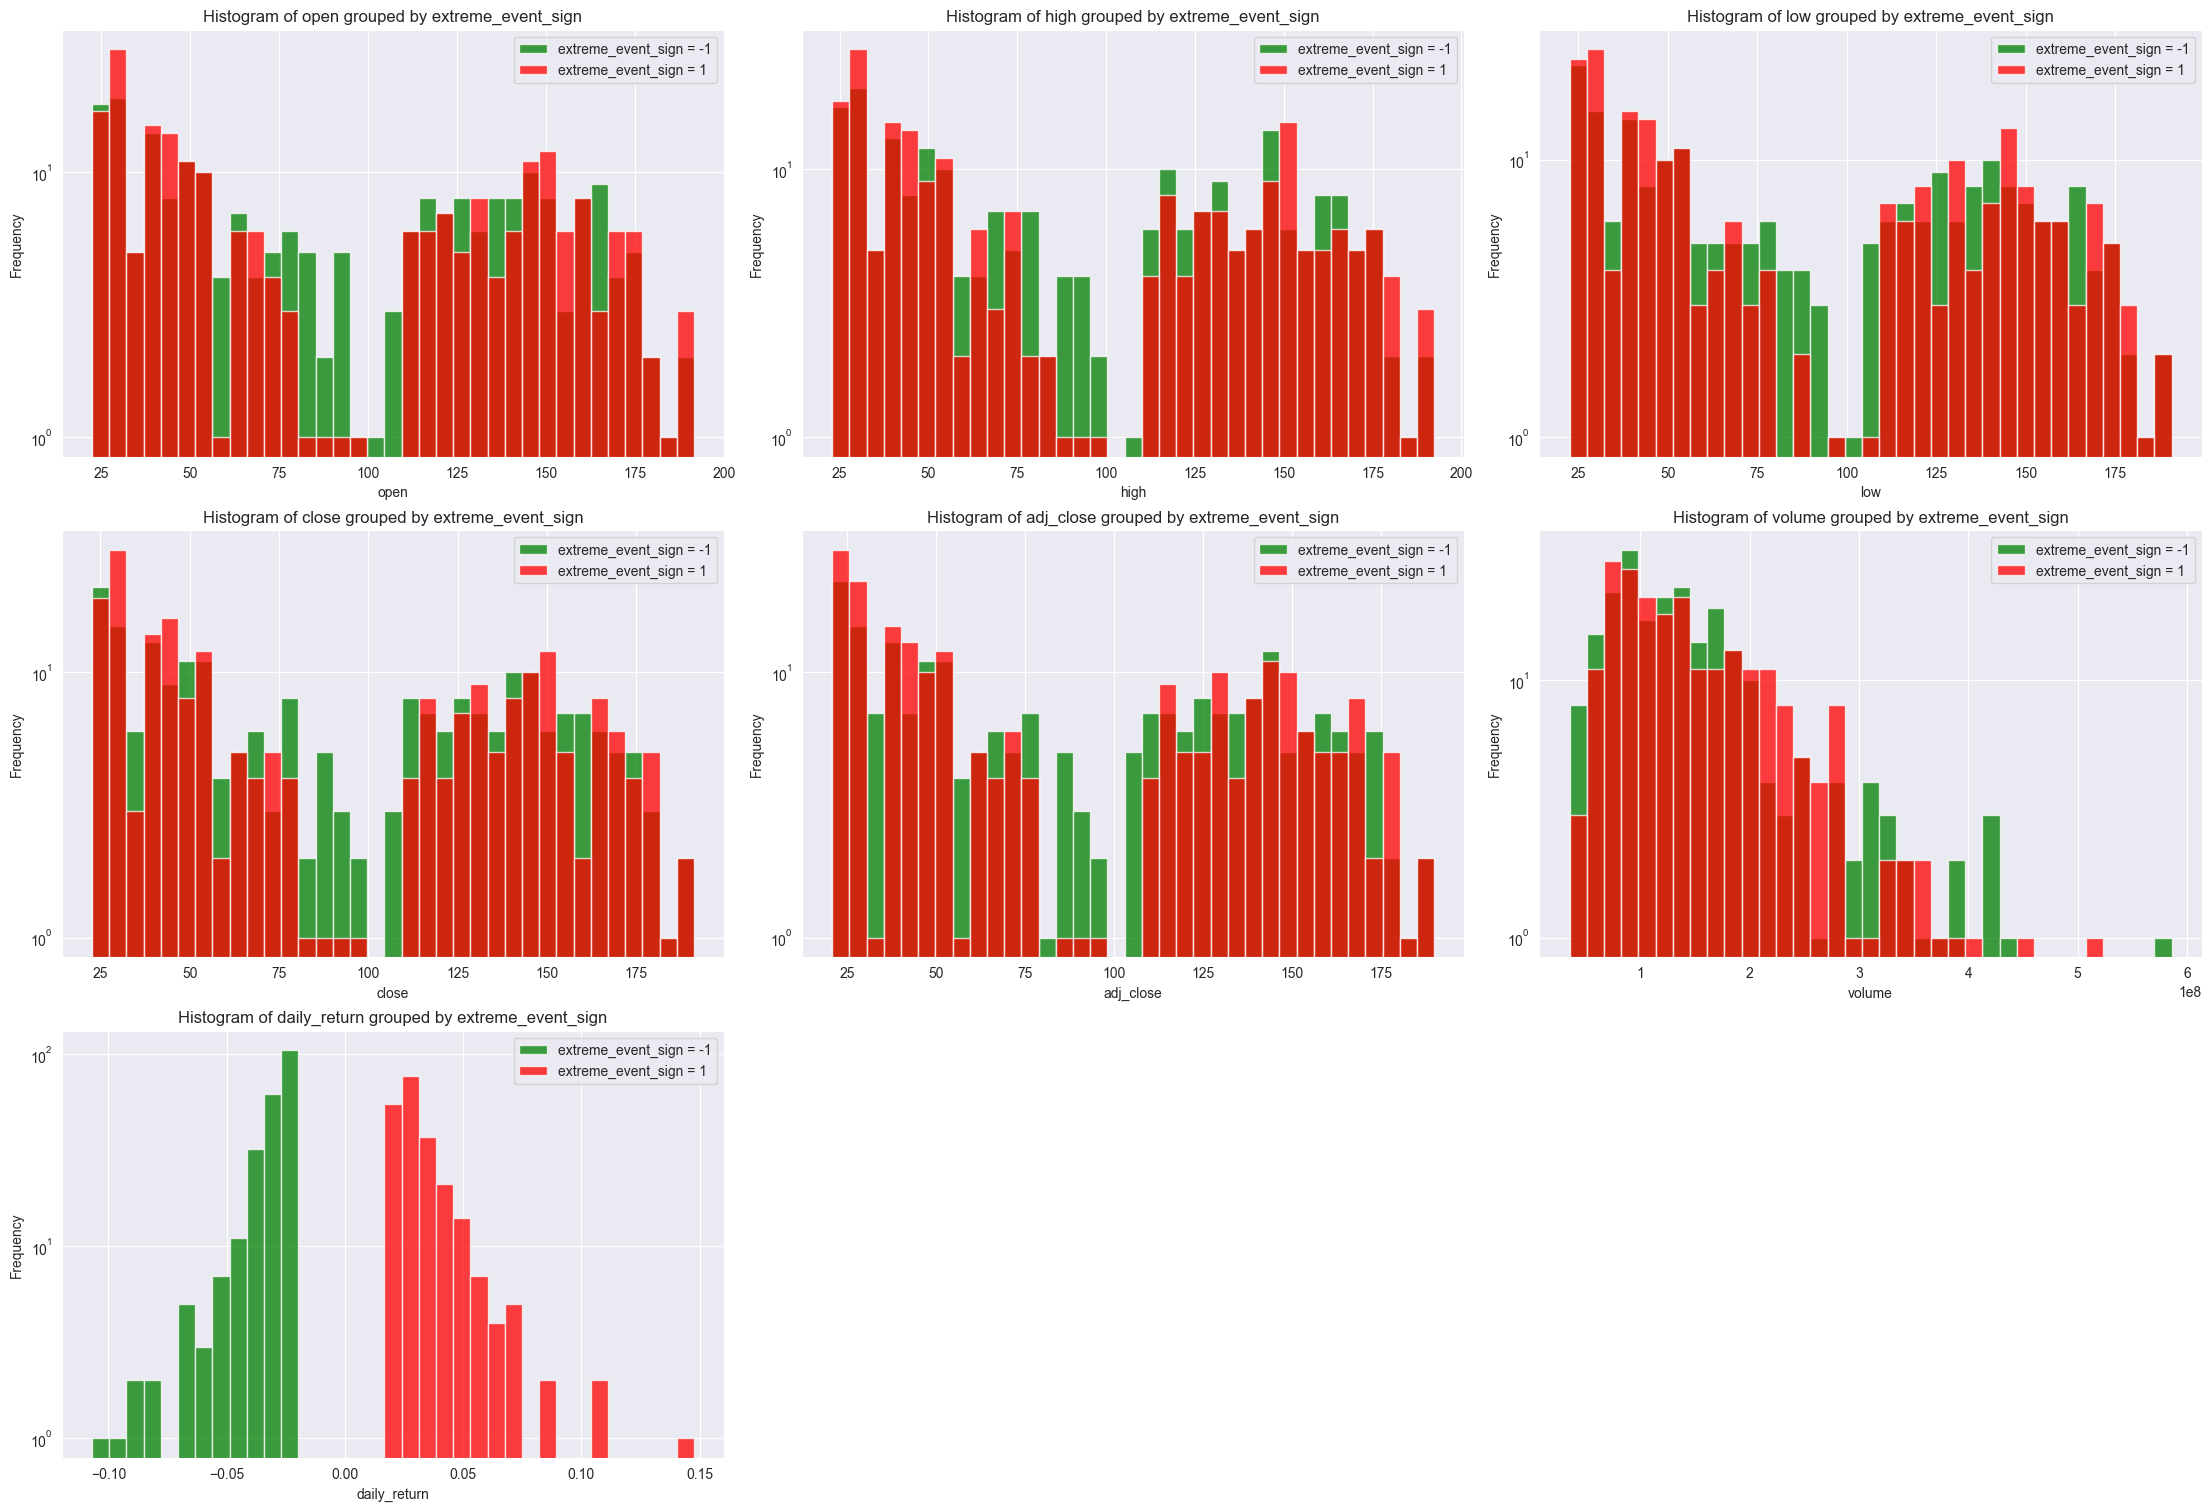

In [18]:
df = df[df['extreme_event']==1]
df = df.loc[:,df.columns!='extreme_event']
#data.loc[:, data.columns != 'name']
# Define the grouping column and color dictionary
group_column = 'extreme_event_sign'
color_dict = {-1: 'green', +1: 'red'}  # Adjust keys to match actual unique values in extreme_event
n_cols = 3  # Number of columns in the grid layout
n_rows = (len(df.columns) - 1) // n_cols + 1  # Calculate rows needed, excluding 'extreme_event'
# Set up the figure and axes for the grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5 * n_rows), constrained_layout=True)
# Flatten axes to make it easier to iterate, even for single rows/columns
axes = axes.flatten()
# Loop through each column except the grouping column
for i, plot_column in enumerate([col for col in df.columns if col != group_column]):
    # Calculate the global min and max for each plot_column
    global_min = df[plot_column].min()
    global_max = df[plot_column].max()
    num_bins = 35  # Set the desired number of bins
    # Define global bin edges across the column's min and max range
    bin_edges = np.linspace(global_min, global_max, num_bins + 1)
    # Loop through each group in the grouping column to plot on the same subplot
    for name, group in df.groupby(group_column):
        custom_color = color_dict.get(name, 'blue')  # Use color from dictionary, default to 'blue' if not found
        axes[i].hist(group[plot_column], bins=bin_edges, alpha=0.75, label=f'{group_column} = {name}', log = True, color=custom_color)
    # Set labels, title, and legend for each subplot
    axes[i].set_xlabel(plot_column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {plot_column} grouped by {group_column}')
    axes[i].legend()
# Hide any empty subplots if there are extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

# Distribution of days
## checking whether 0 or 1 has a preference


In [19]:
#check the distributions based on extreme event flag
pd.DataFrame(input_data.groupby('extreme_event').size())


,0
extreme_event,
0,1807
1,456


# Distribution of name days for across all data

In [20]:
input_data['day_name'] = input_data.index.day_name()
pd.DataFrame(input_data.day_name.value_counts())

C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\703319831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['day_name'] = input_data.index.day_name()


,count
day_name,
Tuesday,465
Wednesday,465
Thursday,459
Friday,453
Monday,421


C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\1707172657.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)


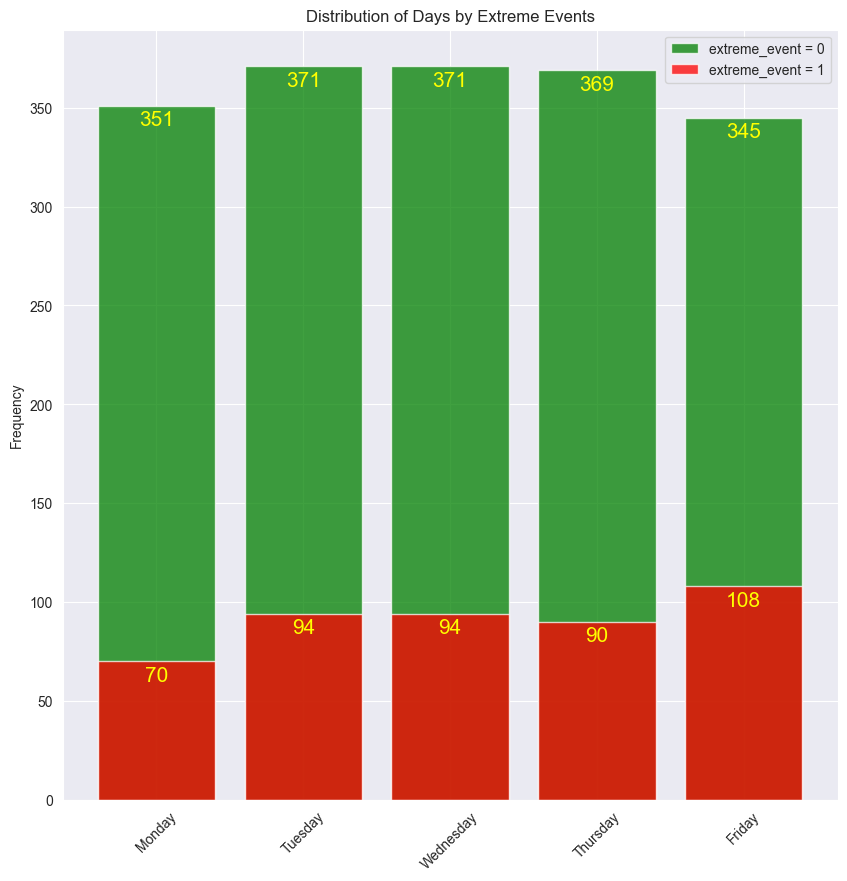

In [21]:
# Group data by 'extreme_event'
df = input_data
# Define custom day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
# Ensure day_name is categorical with the specified order
df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)
# Define colors for each extreme_event
colors = {0: 'green', 1: 'red'}
# Create bins and initialize plot
bins = range(len(day_order) + 1)
plt.figure(figsize=(10, 10))
# Group data by 'extreme_event' and plot
for event in [0,1]:
    # Count occurrences for each day in the custom order
    counts = df[df['extreme_event'] == event]['day_name'].value_counts().reindex(day_order, fill_value=0)

    # Plot the histogram manually with the correct order
    plt.bar(
        counts.index,
        counts.values,
        alpha=0.75,
        color=colors[event],
        label=f'extreme_event = {event}'
    )

    # Annotate bins with counts
    for i, count in enumerate(counts.values):
        if count > 0:  # Only annotate non-zero bins
            plt.text(i, count - 10, str(count), ha='center', fontsize=15,color='yellow')

# Customize the plot
#plt.xlabel('Day Name')
plt.ylabel('Frequency')
plt.title('Distribution of Days by Extreme Events')
plt.xticks(rotation=45)  # Custom x-axis order
plt.legend()
plt.show()

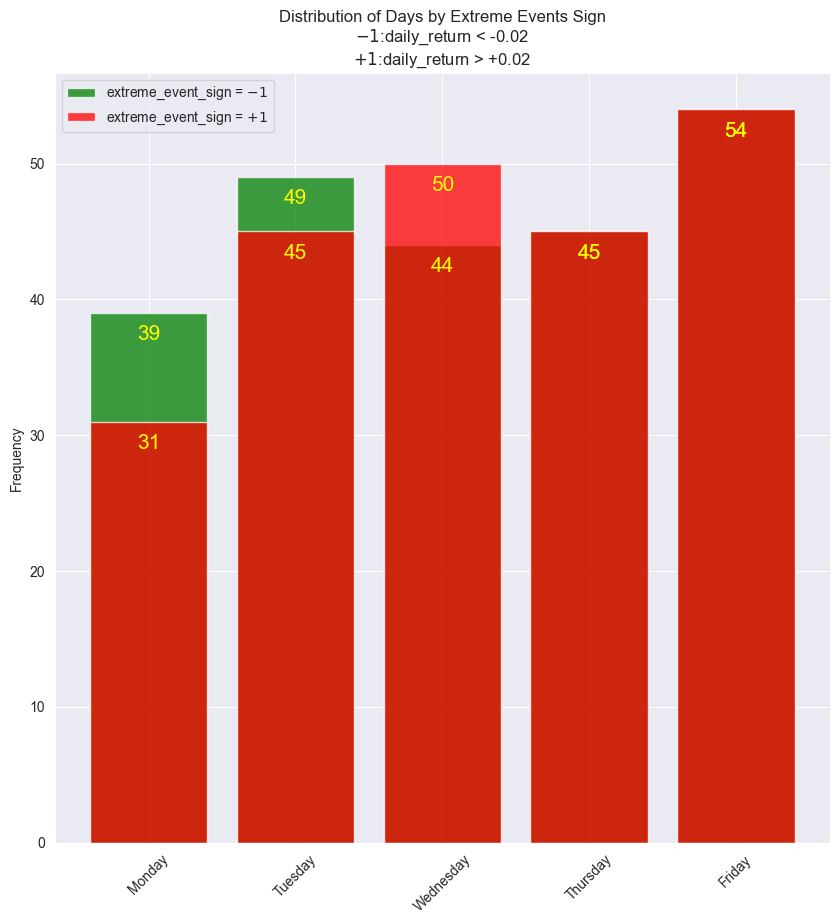

In [42]:
#create extreme_pos and extreme_neg based on the sign of daily_returns
df = input_data.copy()
df['extreme_pos']        = np.where(np.sign(df['daily_return'])*df['extreme_event']==+1,+1,0)
df['extreme_neg']        = np.where(np.sign(df['daily_return'])*df['extreme_event']==-1,-1,0)
df['extreme_event_sign'] = df['extreme_neg'] + df['extreme_pos']
df.drop(['extreme_pos','extreme_neg'],axis=1,inplace=True)
# Define custom day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
# Ensure day_name is categorical with the specified order
df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)
# Define colors for each extreme_event
colors = {-1: 'green', +1: 'red'}
# Create bins and initialize plot
bins = range(len(day_order) + 1)
plt.figure(figsize=(10, 10))
# Group data by 'extreme_event' and plot
for event in [-1,+1]:
    # Count occurrences for each day in the custom order
    counts = df[df['extreme_event_sign'] == event]['day_name'].value_counts().reindex(day_order, fill_value=0)
    if event==1:
        event_lab="+1"
    else:
        event_lab="-1"
    # Plot the histogram manually with the correct order
    plt.bar(
        counts.index,
        counts.values,
        alpha=0.75,
        color=colors[event],
        label=f'extreme_event_sign = ${event_lab}$'
    )

    # Annotate bins with counts
    for i, count in enumerate(counts.values):
        if count > 0:  # Only annotate non-zero bins
            plt.text(i, count - 2, str(count), ha='center', fontsize=15,color='yellow')

# Customize the plot
#plt.xlabel('Day Name')
plt.ylabel('Frequency')
plt.title(f'Distribution of Days by Extreme Events Sign\n$-1$:daily_return < -{margin}\n$+1$:daily_return > +{margin}')
plt.xticks(rotation=45)  # Custom x-axis order
plt.legend()
plt.show()

# Friday seems a preferred date for the extreme events
## but Wednesday seem to be more favorable for positive events
## as opposed to Monday and Tuesday that is more favorable for negative events

In [23]:
#split into extreme_event or not and check the above values. SEEM OK
pd.DataFrame(input_data.groupby('extreme_event').day_name.value_counts())

count
extreme_event day_name        
0             Tuesday      371
              Wednesday    371
              Thursday     369
              Monday       351
              Friday       345
1             Friday       108
              Tuesday       94
              Wednesday     94
              Thursday      90
              Monday        70

In [24]:
#keep the x_i's and Y that will be used for modelling
#For time-series data, ensure the model is only trained on past data and tested on future data, preserving temporal order.
final_input_data = input_data[[col for col in input_data.columns if col not in ['adj_close','day_name']]]
final_input_data

,open,high,low,close,volume,daily_return,extreme_event
date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400,0.028988,1
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000,-0.000094,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400,-0.013829,0
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600,-0.037000,1
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000,-0.001071,0
...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,46482500,0.005578,0
2023-12-22,195.179993,195.410004,192.970001,193.600006,37122800,0.002849,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,28919300,-0.000518,0


# Introducing shift to the target variable Extreme_Event by one day
### so that the model is trained to predict if an extreme event occurs tomorrow based on today's data.


In [25]:
final_input_data['extreme_event'] = final_input_data['extreme_event'].shift(-1)
final_input_data.dropna(inplace=True)
final_input_data['extreme_event'] = final_input_data['extreme_event'].astype(int)
final_input_data

C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\3808394915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input_data['extreme_event'] = final_input_data['extreme_event'].shift(-1)
C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\3808394915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input_data.dropna(inplace=True)
C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\3808394915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,open,high,low,close,volume,daily_return,extreme_event
date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400,0.028988,0
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000,-0.000094,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400,-0.013829,1
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600,-0.037000,0
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000,-0.001071,1
...,...,...,...,...,...,...,...
2023-12-20,196.899994,197.679993,194.830002,194.830002,52242800,0.000771,0
2023-12-21,196.100006,197.080002,193.500000,194.679993,46482500,0.005578,0
2023-12-22,195.179993,195.410004,192.970001,193.600006,37122800,0.002849,0


In [26]:
final_input_data[0:15]

,open,high,low,close,volume,daily_return,extreme_event
date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400,0.028988,0
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000,-0.000094,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400,-0.013829,1
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600,-0.037000,0
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000,-0.001071,1
2015-01-09,28.167500,28.312500,27.552500,28.002501,214798000,0.025263,0
2015-01-12,28.150000,28.157499,27.200001,27.312500,198603200,-0.008801,0
2015-01-13,27.857500,28.200001,27.227501,27.555000,268367600,0.003825,1
2015-01-14,27.260000,27.622499,27.125000,27.450001,195826400,0.027898,0


## Introducing LAG
### To predict a binary outcome (y = 0 or 1) using the past 10 days of historical data,
### we can structure your data such that each row contains the historical data for the past 10 days,
### and the target variable y is the value for the prediction (either 0 or 1).
### Use the values from the previous 10 days as features (X).
### Create an empty list to store all lag features


In [27]:
lag_features  = []
window_size   = 10
target_column = 'extreme_event'
df = final_input_data.copy()
# Loop through each column and create the lag features
for i in range(1, window_size + 1):
    for col in df.columns:
        if col != target_column:  #Skip the target variable
            if i < 10:
                lag_features.append(df[col].shift(i).rename(f'{col}_lag0{i}'))#01,02,etc
            else:
                lag_features.append(df[col].shift(i).rename(f'{col}_lag{i}'))#10
# rename the initial columns by Adding `_lag00` in the initial columns
tempo=[]
for col in df.columns:
    if col != target_column:
        tempo.append(f'{col}_lag00')
    else:
        tempo.append(f'{col}')
df.columns=tempo
final_input_data_lagged = pd.concat([df] + lag_features, axis=1)# Concatenate all lag features as new columns to the original dataframe
final_input_data_lagged = final_input_data_lagged.dropna()# Drop rows with NaN values (the first 'window_size' rows will have NaNs)
final_input_data_lagged = final_input_data_lagged.reindex(sorted(final_input_data_lagged.columns), axis=1)#sort the colnames alphanumerically
final_input_data_lagged.insert(0,target_column,final_input_data_lagged.pop(target_column))#re-arrange the target column@1st place
final_input_data_lagged[0:20]

,extreme_event,close_lag00,close_lag01,close_lag02,close_lag03,close_lag04,close_lag05,close_lag06,close_lag07,close_lag08,close_lag09,close_lag10,daily_return_lag00,daily_return_lag01,daily_return_lag02,daily_return_lag03,daily_return_lag04,daily_return_lag05,daily_return_lag06,daily_return_lag07,daily_return_lag08,daily_return_lag09,daily_return_lag10,high_lag00,high_lag01,high_lag02,high_lag03,high_lag04,high_lag05,high_lag06,high_lag07,high_lag08,high_lag09,high_lag10,low_lag00,low_lag01,low_lag02,low_lag03,low_lag04,low_lag05,low_lag06,low_lag07,low_lag08,low_lag09,low_lag10,open_lag00,open_lag01,open_lag02,open_lag03,open_lag04,open_lag05,open_lag06,open_lag07,open_lag08,open_lag09,open_lag10,volume_lag00,volume_lag01,volume_lag02,volume_lag03,volume_lag04,volume_lag05,volume_lag06,volume_lag07,volume_lag08,volume_lag09,volume_lag10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-16,0,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,27.332500,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,-0.000094,0.028988,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.162500,27.860001,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,26.352501,26.837500,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,27.072500,27.847500,314053200,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0,212818400.0
2015-01-20,1,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,-0.000094,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.162500,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,26.352501,26.959999,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,27.072500,199599600,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0
2015-01-21,0,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,-0.025356,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,-0.013829,27.764999,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,26.857500,27.067499,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,26.157499,27.237499,26.959999,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,26.635000,194303600,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0
2015-01-22,0,28.100000,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,-0.005134,-0.025356,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,-0.037000,28.117500,27.764999,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.312500,28.037500,27.049999,27.430000,27.067499,26.625000,26.299999,26.665001,27.125000,27.227501,27.200001,27.552500,27.174999,26.674999,27.565001,27.237499,26.959999,26.757500,27.500000,27.260000,27.857500,28.150000,28.167500,27.307501,26.799999,215185600,194303600.0,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0
2015-01-23,1,28.245001,28.100000,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,-0.001061,-0.005134,-0.025356,-0.007576,-0.025111,0.007831,0.027898,0.003825,-0.008801,0.025263,-0.001071,28.437500,28.117500,27.764999,27.242500,26.895000,27.514999,27.622499,28.200001,28.157499,28.

In [28]:
# SPLIT 70-15-15
# For time series data, it's important to maintain the temporal order
#
# Step 1: Split the data into 70% for training and 30% for both validation and test
train_data, temp_data = train_test_split(final_input_data_lagged, test_size=0.3, shuffle=False)
# Step 2: Now, split the remaining 30% into 50% for validation and 50% for testing
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)
# Check the sizes of the splits
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 1576
Validation data size: 338
Test data size: 338


In [29]:
with open("./data/split_dataset.pickle",'wb') as f:
    pickle.dump([train_data,val_data,test_data],f)

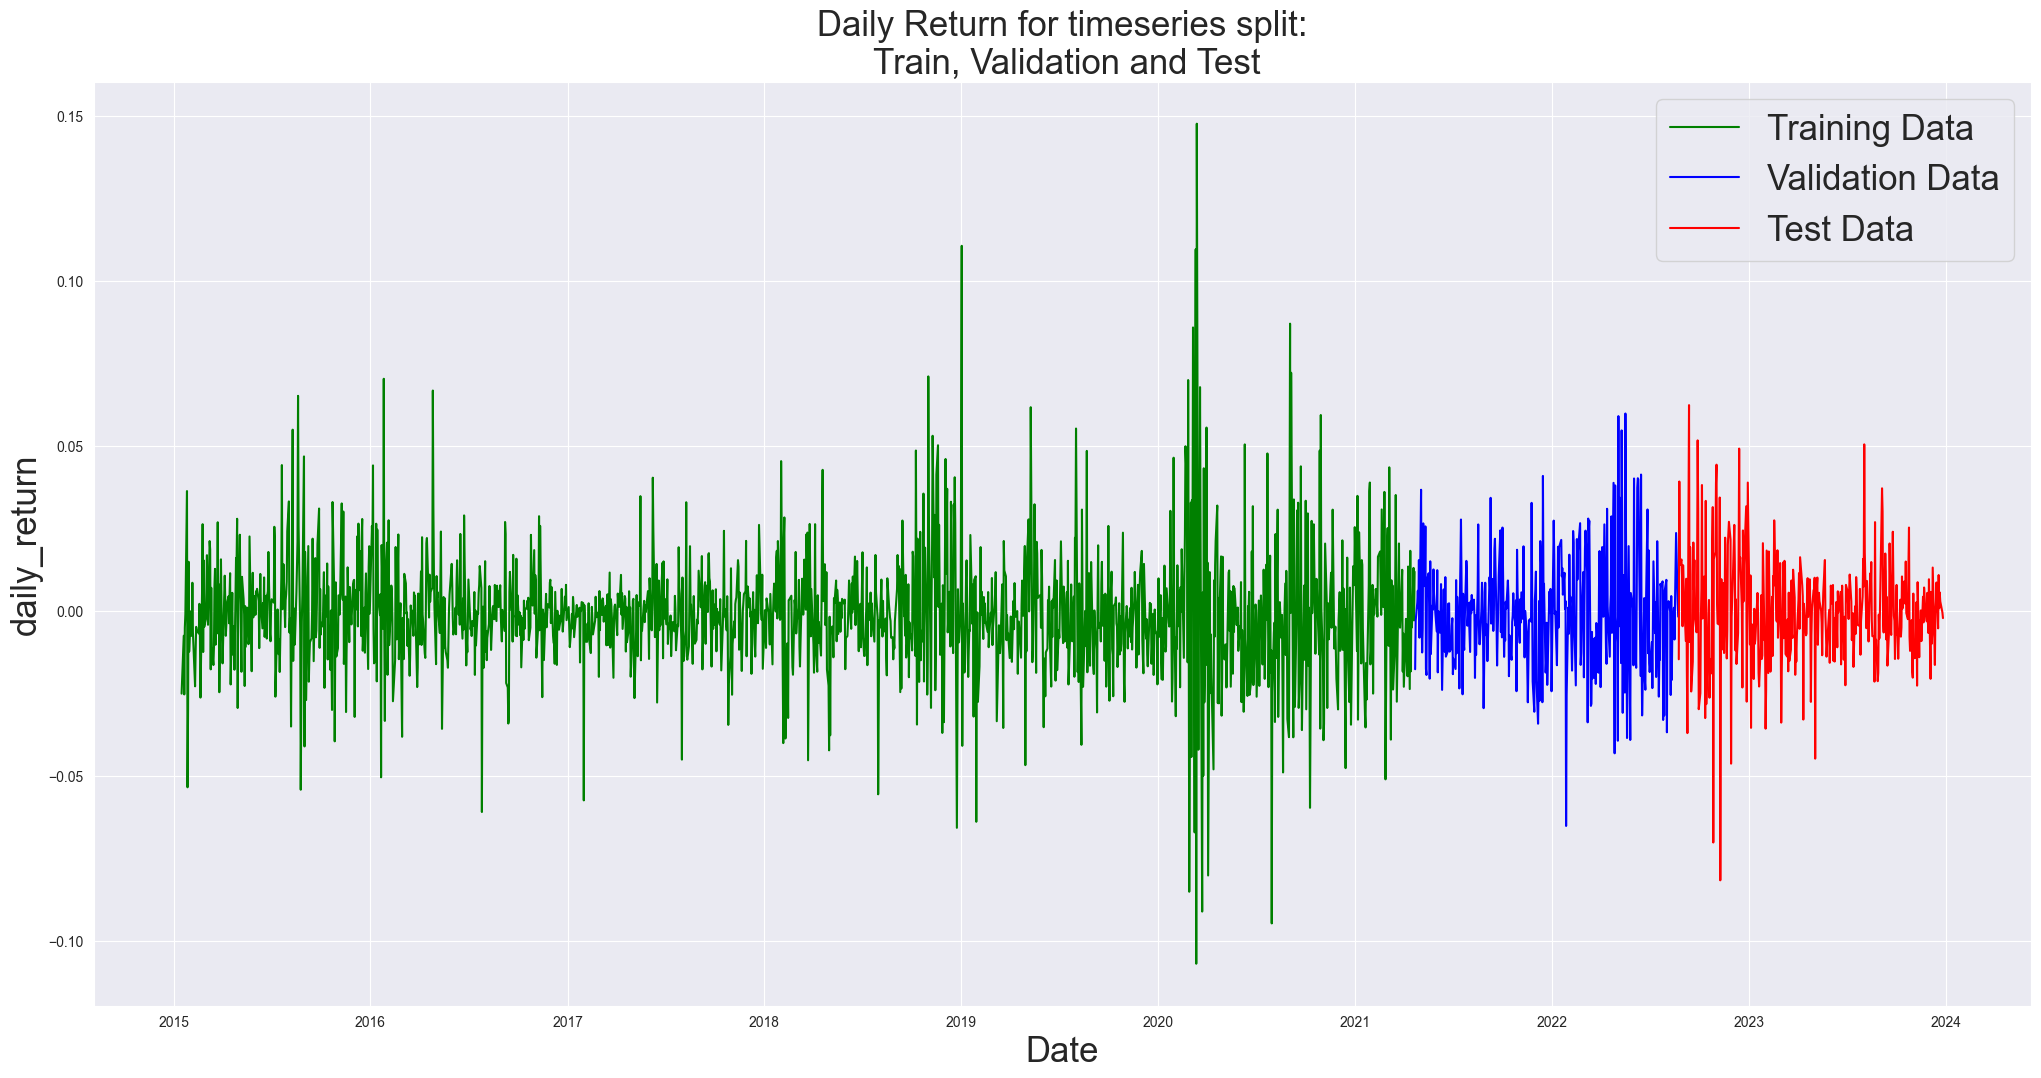

In [44]:
# Plot training data 
plt.figure(figsize=(25, 12))  # Change (width, height) as needed
plt.plot(train_data.index, train_data['daily_return_lag00'], label='Training Data', color='green')
# Plot validation data
plt.plot(val_data.index, val_data['daily_return_lag00'], label='Validation Data', color='blue')
# Plot test data
plt.plot(test_data.index, test_data['daily_return_lag00'], label='Test Data', color='red')
# Add labels, title, and legend
plt.xlabel('Date',fontsize=25)  # Adjust based on your index
plt.ylabel('daily_return',fontsize=25)  # Adjust based on your data column
plt.title('Daily Return for timeseries split:\n Train, Validation and Test',fontsize=25)
plt.legend(fontsize=25)
# Show the plot
plt.show()#SEEMS OK

# calculate the time diff between two adjacent events pos OR neg
## pos2pos 
## neg2neg
## pos2neg
## neg2pos

<Axes: xlabel='last_timestamp_pos'>

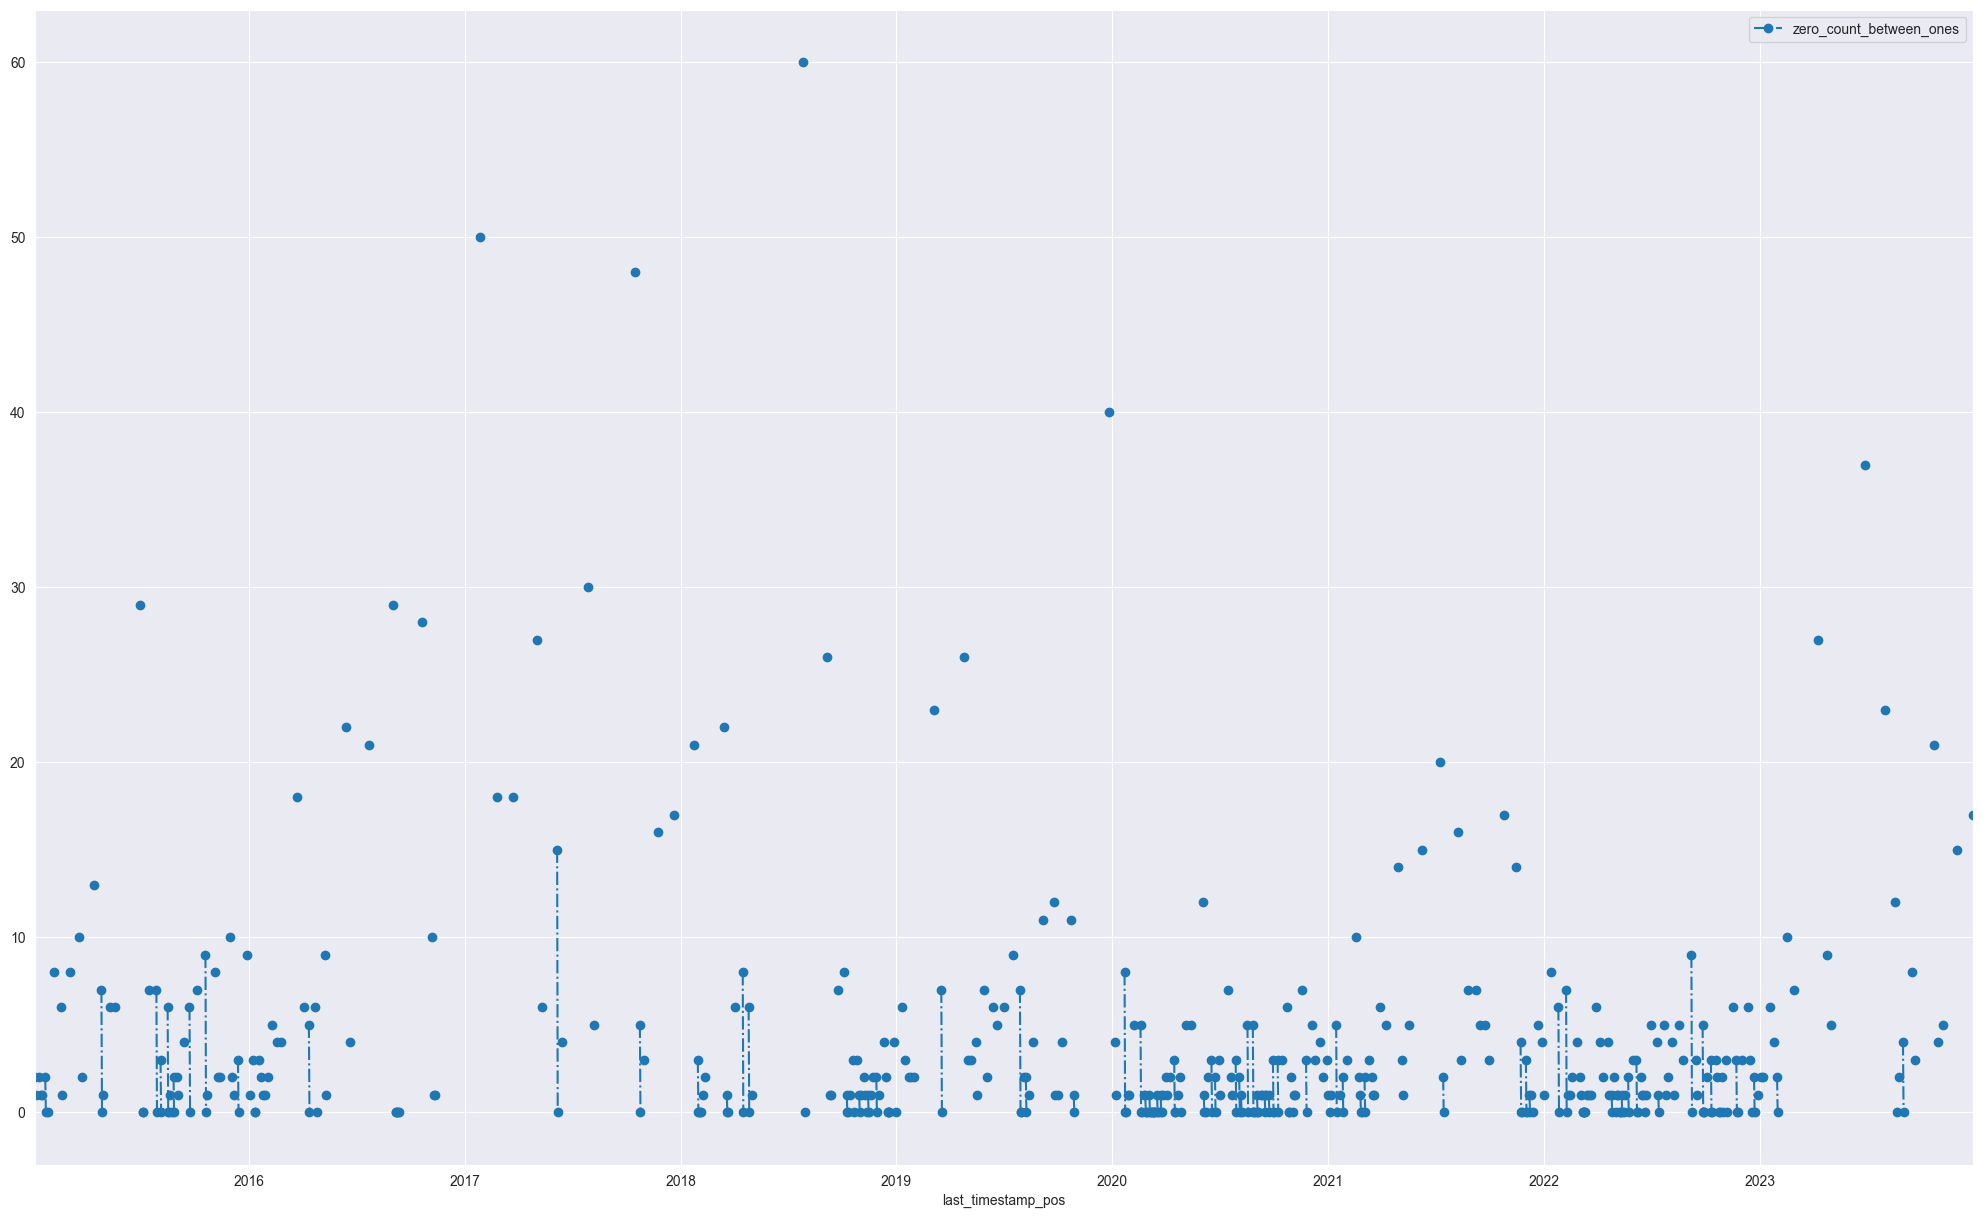

In [31]:
#overview of extreme events
df = final_input_data.copy()
df.reset_index(inplace=True)
# Create a 'segment' column to group zeros between ones
df['segment'] = (df['extreme_event'] == 1).cumsum()

# Count zeros in each segment, ignoring segments without zeros between ones
zero_counts = df[df['extreme_event'] == 0].groupby('segment').size()#.reset_index(name='zero_count_between_ones')
df['zero_count_between_ones'] = df['segment'].map(zero_counts).fillna(0).astype(int)

# Get the last timestamp of each segment (where 'IsExtreme' is 1)
df['last_timestamp_pos'] = df.groupby('segment')['date'].transform('last')

# Remove the helper 'segment' column if no longer needed
df = df.drop(columns='segment')
df[['last_timestamp_pos','zero_count_between_ones']].drop_duplicates().set_index('last_timestamp_pos').resample('D').asfreq().plot(marker='o',linestyle='-.',figsize=(25,15))

<Axes: >

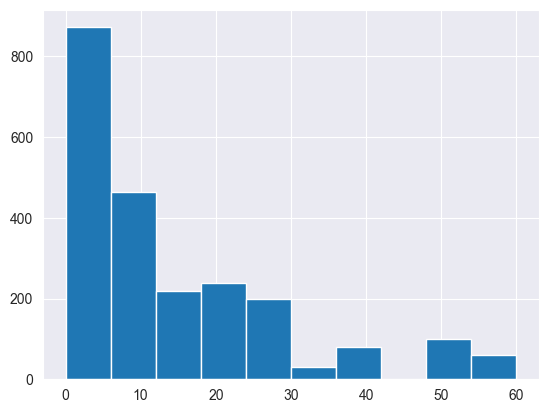

In [32]:
df['zero_count_between_ones'].hist()

In [33]:
#create extreme_pos and extreme_neg based on the sign of daily_returns
final_input_data['extreme_pos'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==+1,1,0)
final_input_data['extreme_neg'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==-1,1,0)

C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\3331933721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input_data['extreme_pos'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==+1,1,0)
C:\Users\agerom\AppData\Local\Temp\ipykernel_15876\3331933721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input_data['extreme_neg'] = np.where(np.sign(final_input_data['daily_return'])*final_input_data['extreme_event']==-1,1,0)


mean 13 days 15:07:33.781512605
std 20 days 07:49:06.623963687
mean_error 1 days 07:33:15.681838988


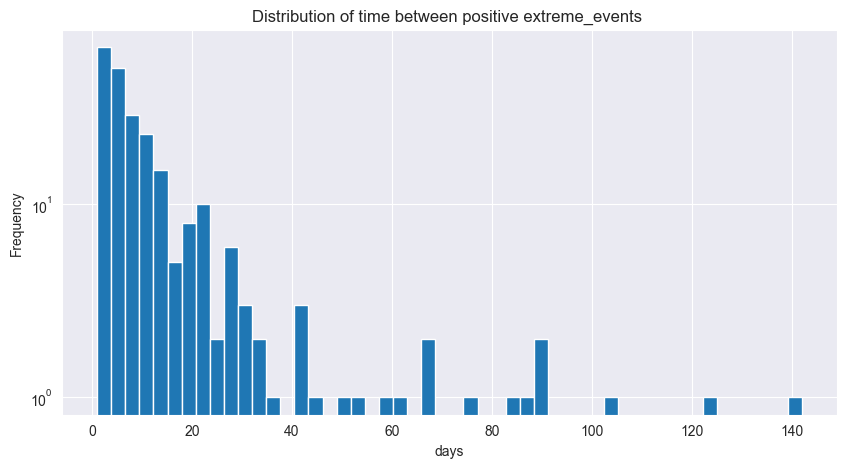

In [34]:
tmp = final_input_data[final_input_data['extreme_pos']==1].reset_index()[['date']]
tmp['date_diff'] = (tmp.date.shift(-1)-tmp.date)#.dt.total_seconds()
print("mean",tmp['date_diff'].mean())
print("std",tmp['date_diff'].std())
print("mean_error",tmp['date_diff'].std()/np.sqrt(tmp.shape[0]))
(tmp['date_diff'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between positive extreme_events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

mean 15 days 04:31:41.886792452
std 19 days 23:38:34.299481630
mean_error 1 days 08:51:52.514310256


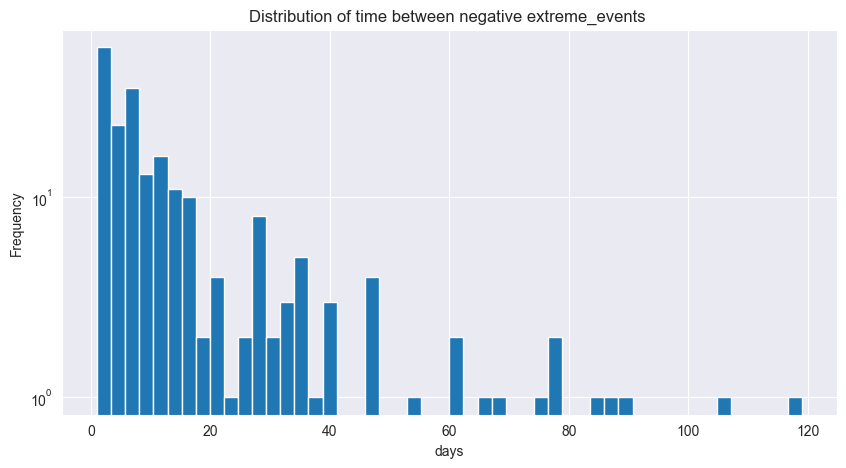

In [35]:
tmp = final_input_data[final_input_data['extreme_neg']==1].reset_index()[['date']]
tmp['date_diff'] = (tmp.date.shift(-1)-tmp.date)#.dt.total_seconds()
print("mean",tmp['date_diff'].mean())
print("std",tmp['date_diff'].std())
print("mean_error",tmp['date_diff'].std()/np.sqrt(tmp.shape[0]))
(tmp['date_diff'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between negative extreme_events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

In [36]:
#A) keep only rows extreme_pos-> extreme_neg
df = final_input_data[final_input_data['extreme_event']==1][['extreme_pos','extreme_neg']]
# Ensure the data is sorted by Date to calculate time differences correctly
df.sort_index(inplace=True)
df.reset_index(inplace=True)
# Shift the Pos and Neg columns to compare consecutive rows
df['prev_pos']  = df['extreme_pos'].shift(1)
df['prev_date'] = df['date'].shift(1)
#Identify rows where `Pos` changes to `Neg` (Pos was True, Neg is now True)
pos_to_neg_mask = (df['prev_pos'] == True) & (df['extreme_neg'] == True)
# Calculate the time difference for rows matching the mask
df['time_diff_pos2neg'] = df['date'] - df['prev_date']
df['time_diff_pos2neg'] = df['time_diff_pos2neg'].where(pos_to_neg_mask)
print("mean",df['time_diff_pos2neg'].mean())
print("std",df['time_diff_pos2neg'].std())
print("mean_error",df['time_diff_pos2neg'].std()/np.sqrt(df.shape[0]))
df

mean 6 days 18:46:57.391304347
std 8 days 20:58:46.724832311
mean_error 0 days 09:59:04.703275517


,date,extreme_pos,extreme_neg,prev_pos,prev_date,time_diff_pos2neg
0,2015-01-06,0,1,NaN,NaT,NaT
1,2015-01-08,0,1,0.0,2015-01-06,NaT
2,2015-01-13,1,0,0.0,2015-01-08,NaT
3,2015-01-15,1,0,1.0,2015-01-13,NaT
4,2015-01-20,0,1,1.0,2015-01-15,5 days
...,...,...,...,...,...,...
450,2023-09-22,0,1,0.0,2023-09-18,NaT
451,2023-10-24,1,0,0.0,2023-09-22,NaT
452,2023-10-31,0,1,1.0,2023-10-24,7 days
453,2023-11-08,1,0,0.0,2023-10-31,NaT


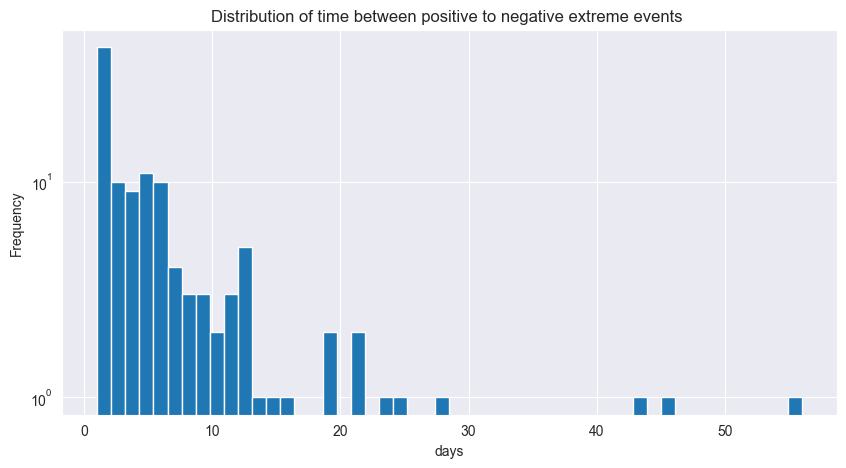

In [37]:
(df['time_diff_pos2neg'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5));
plt.title("Distribution of time between positive to negative extreme events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()

In [38]:
#B) keep only rows extreme_neg -> extreme_pos
df = final_input_data[final_input_data['extreme_event']==1][['extreme_pos','extreme_neg']]
# Ensure the data is sorted by Date to calculate time differences correctly
df.sort_index(inplace=True)
df.reset_index(inplace=True)
# Shift the Pos and Neg columns to compare consecutive rows
df['prev_neg']  = df['extreme_neg'].shift(1)
df['prev_date'] = df['date'].shift(1)
# Identify rows where `Neg` changes to `Pos` (Neg was True, Pos is now True)
neg_to_pos_mask = (df['prev_neg'] == True) & (df['extreme_pos'] == True)
# Calculate the time difference for rows matching the mask
df['time_diff_neg2pos'] = df['date'] - df['prev_date']
df['time_diff_neg2pos'] = df['time_diff_neg2pos'].where(neg_to_pos_mask)
print("mean",df['time_diff_neg2pos'].mean())
print("std",df['time_diff_neg2pos'].std())
print("mean_error",df['time_diff_neg2pos'].std()/np.sqrt(df.shape[0]))
df

mean 8 days 06:58:27.692307692
std 12 days 20:45:11.844458417
mean_error 0 days 14:28:28.478995589


,date,extreme_pos,extreme_neg,prev_neg,prev_date,time_diff_neg2pos
0,2015-01-06,0,1,NaN,NaT,NaT
1,2015-01-08,0,1,1.0,2015-01-06,NaT
2,2015-01-13,1,0,1.0,2015-01-08,5 days
3,2015-01-15,1,0,0.0,2015-01-13,NaT
4,2015-01-20,0,1,0.0,2015-01-15,NaT
...,...,...,...,...,...,...
450,2023-09-22,0,1,1.0,2023-09-18,NaT
451,2023-10-24,1,0,1.0,2023-09-22,32 days
452,2023-10-31,0,1,0.0,2023-10-24,NaT
453,2023-11-08,1,0,1.0,2023-10-31,8 days


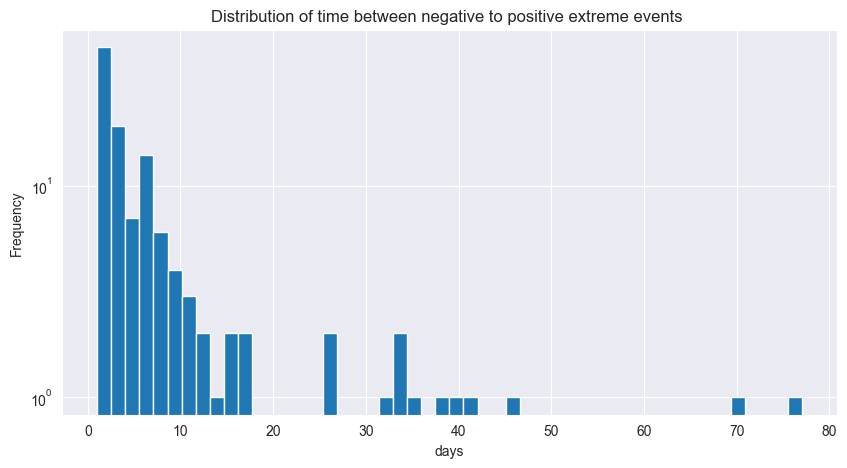

In [39]:
(df['time_diff_neg2pos'].dt.total_seconds()/(24*3600)).hist(log=True,bins=50,figsize=(10,5))
plt.title("Distribution of time between negative to positive extreme events ")
plt.ylabel('Frequency')
plt.xlabel('days')
plt.show()